## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'segmentAnything-full' 
TRANSFORM = 'wavelet-diagonal'
CHANNEL = 'red'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
red_diagonal_wavelet_full_segmentAnything.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/segmentAnything/full/wavelet/diagonal/red'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 7072,
 3: 28288,
 4: 113152,
 5: 452608,
 6: 1810432,
 7: 7241728,
 8: 28966912,
 9: 115867648,
 10: 463470592}

Running 12760 CDFs


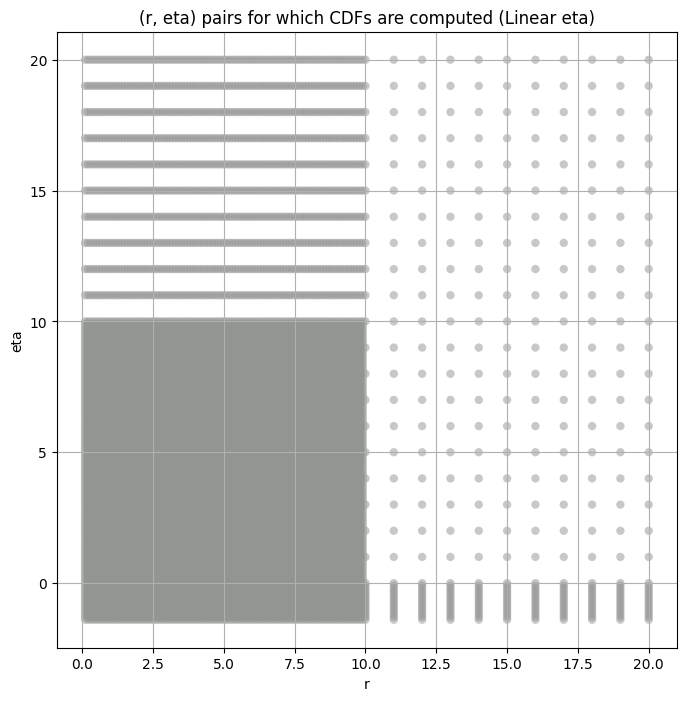

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df['total_samples'] = master_df['total_samples'].astype(int)
    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 10


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      2992.346700  2795.771000  3197.442000   2.840140    2.327932   
3       780.423100   728.603940   834.956850   4.924683    3.954512   
4       197.344920   182.717960   212.721620   6.607422    5.379036   
5        45.919570    42.290737    49.782864   8.213636    6.600699   
6        10.315014     9.406057    11.280571  10.381206    8.092984   
7         2.322034     2.104991     2.558147  12.456102    9.404761   
8         0.556196     0.501761     0.618983  14.527348    9.739854   
9         0.165471     0.149907     0.183561  13.340412    8.399303   
10        0.071800     0.066021     0.078448   9.116372    5.449671   

       kurt_upper  total_samples  
layer                             
2        3.407406           7072  
3        6.222755          28288  
4        8.421290         113152  
5       10.661204         452608  
6       14.631648        1810432  
7       19.237617        7241728  
8       34.173534       28966912  
9       32.501076      115867648  
10      21.428100      463470592

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                               
2      2992.346700    2992.346680     2647.723633     2431.564453   
3       780.423100     780.423096      736.478516      707.823059   
4       197.344920     197.344925      192.483063      188.993408   
5        45.919570      45.919571       44.588768       43.689541   
6        10.315014      10.315014        9.959997        9.727058   
7         2.322034       2.322034        2.231028        2.172821   
8         0.556196       0.556196        0.531415        0.516757   
9         0.165471       0.165471        0.158163        0.153945   
10        0.071800       0.071800        0.069042        0.067505   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2         2259.614746      2115.781982      1885.337280      1700.333008   
3          684.043945       663.317688       628.791321       599.451294   
4          185.971756       183.256088       178.435623       174.216812   
5           42.921776        42.224781        41.000690        39.925262   
6            9.530622         9.356100         9.049668         8.781991   
7            2.124171         2.081166         2.005994         1.940815   
8            0.504601         0.493913         0.475402         0.459475   
9            0.150473         0.147445         0.142245         0.137803   
10           0.066258         0.065182         0.063354         0.061810   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2          1546.301758      1415.568970      1300.237427      1021.720032  
3           573.541077       550.443848       529.180237       475.369415  
4           170.392868       166.855133       163.550201       154.805374  
5            38.947990        38.048904        37.215233        35.021912  
6             8.541603         8.322104         8.119312         7.586808  
7             1.882698         1.829911         1.781394         1.654830  
8             0.445343         0.432564         0.420864         0.390600  
9             0.133885         0.130360         0.127145         0.118860  
10            0.060459         0.059250         0.058151         0.055319

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.010586458452705116 2992.3467


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.010218928617440282 2647.7236


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.013251146616508724 2431.5645


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.017785102004437947 2259.6147


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.021675655065425903 2115.782


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.029649106064642106 1885.3373


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.03699165573291696 1700.333


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.04411601111173025 1546.3018


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.051477933182948576 1415.569


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.05864057677953949 1300.2374


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.08158105672432625 1021.72003
Number of samples: 7072, Without approximation : 7072


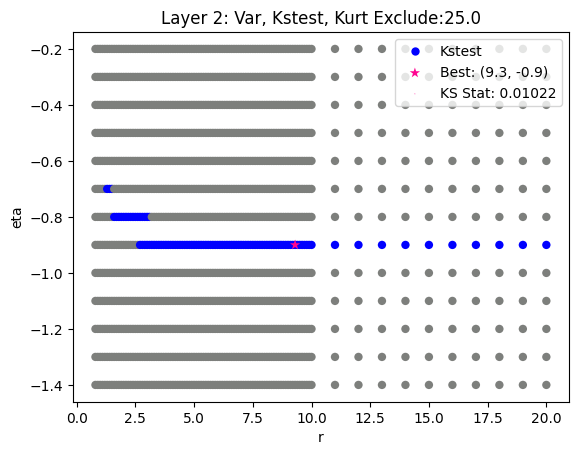

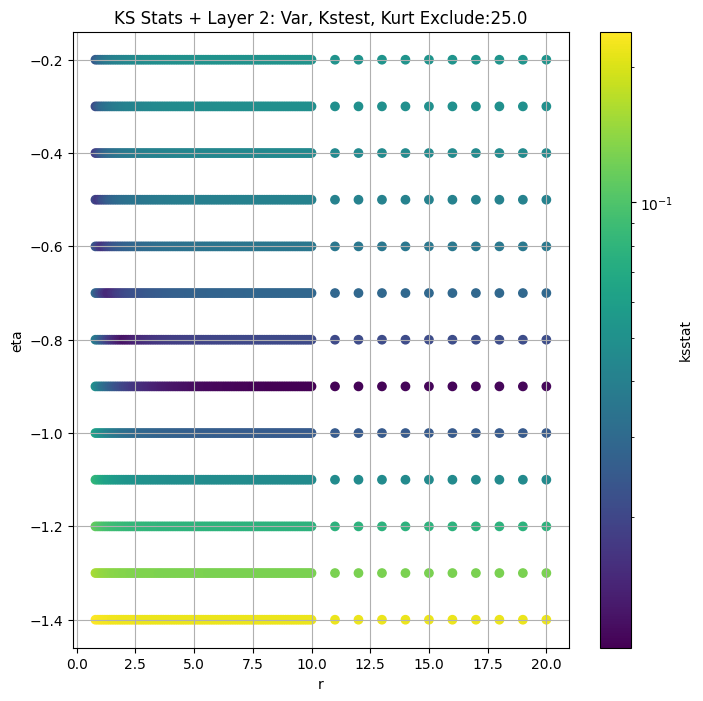

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.005883937822265345 780.4231


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.005402952097920494 736.4785


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.0051181059868768974 707.82306


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.0060632488824249806 684.04395


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.007103789715939116 663.3177


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.009483768757604039 628.7913


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.012154473415205785 599.4513


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.01400015334702568 573.5411


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.01599837175345148 550.44385


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.01785707697339143 529.18024


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.02290501811741906 475.36942
Number of samples: 28288, Without approximation : 28288


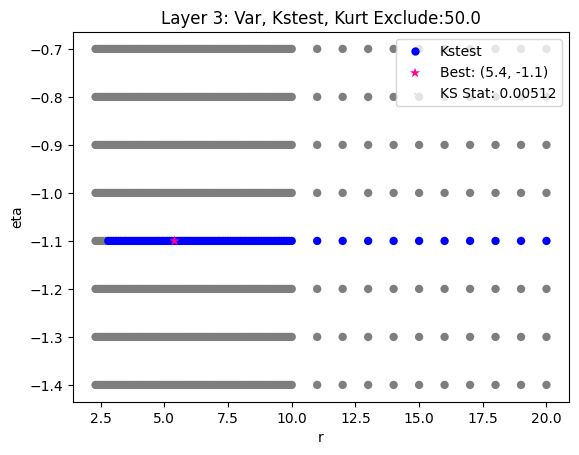

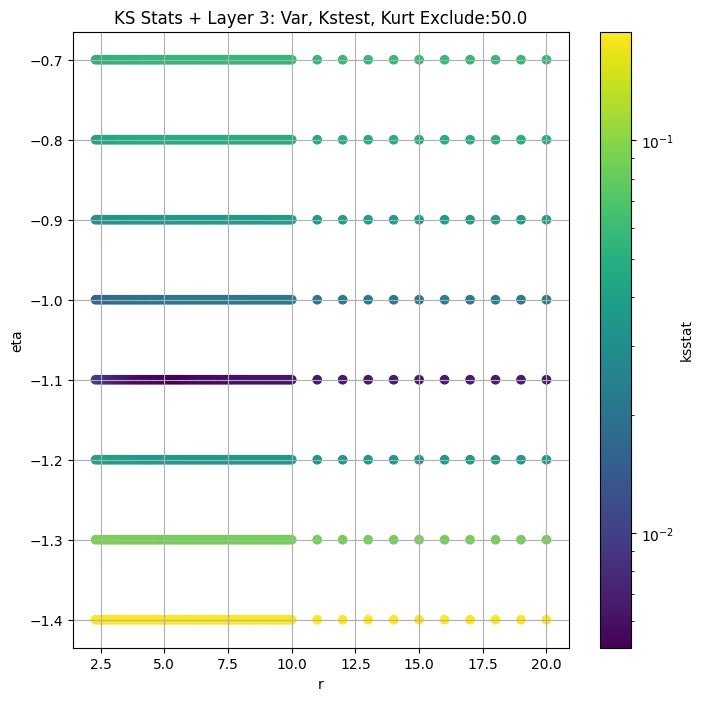

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.007679615491025915 197.34492


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.007528996569364621 192.48306


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.007427594131357518 188.99341


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.007326252426924251 185.97176


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.007230081087759577 183.25609


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.007762341023925978 178.43562


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.008553849923041645 174.21681


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.00929193214871632 170.39287


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.009993150862945444 166.85513


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.01033863439964855 163.5502


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.011181832658481938 154.80537
Number of samples: 100000, Without approximation : 113152


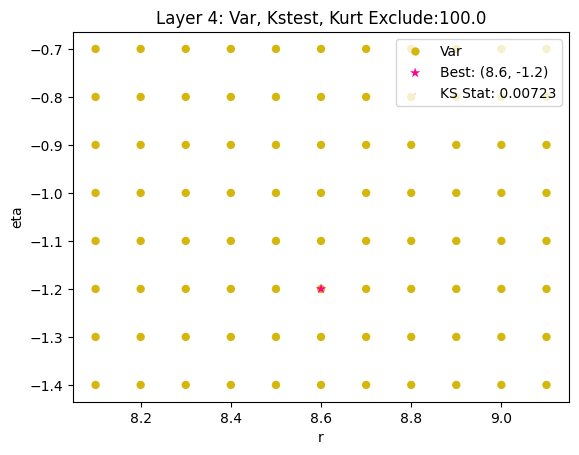

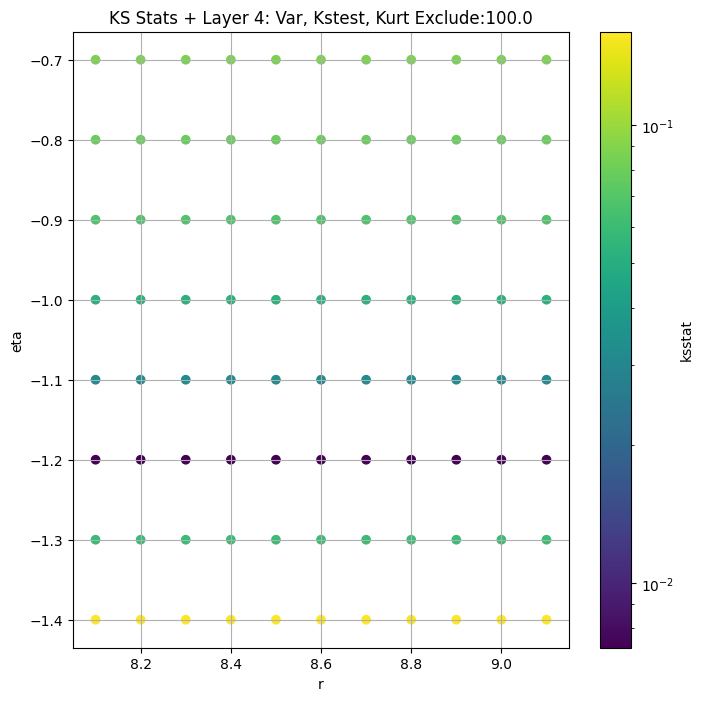

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.013693618335094304 45.91957


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.013693523801232566 44.588768


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.013694431430200937 43.68954


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.013694381846941495 42.921776


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.013694335667949586 42.22478


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.013694251734465979 41.00069


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.01369417483117702 39.925262


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.013694102202207958 38.94799


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.013694032927326516 38.048904


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.013693966462247742 37.215233


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.013694127632230824 35.02191
Number of samples: 100000, Without approximation : 452608


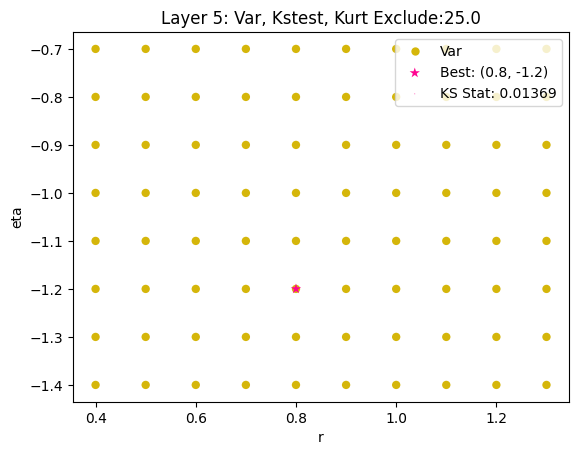

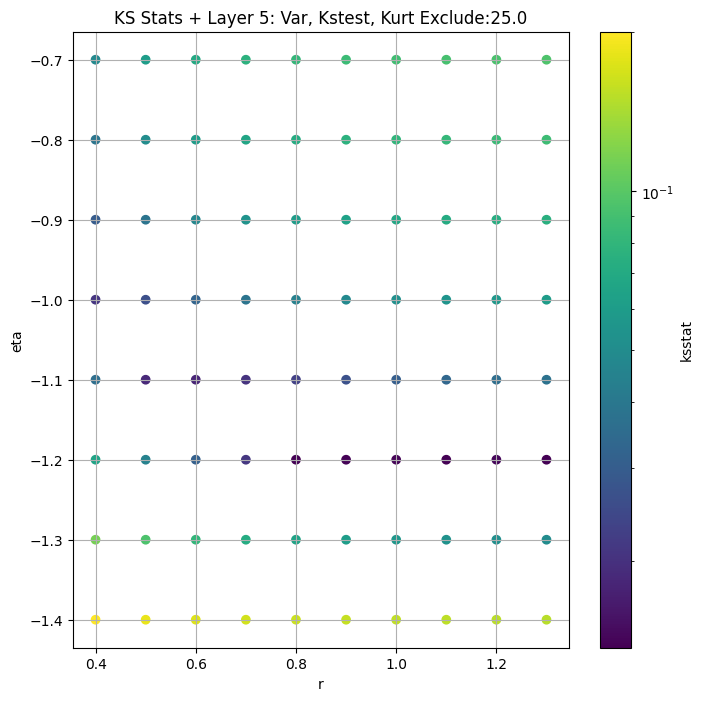

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.03451999999999977 10.315014


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.03451999999999977 9.959997


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.03451999999999977 9.727058


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.03451999999999977 9.530622


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.03451999999999977 9.3561


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.03451999999999977 9.049668


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.03451999999999977 8.781991


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.03451999999999977 8.541603


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.03451999999999977 8.3221035


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.03451999999999977 8.119312


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.03451999999999977 7.586808
Number of samples: 100000, Without approximation : 1810432


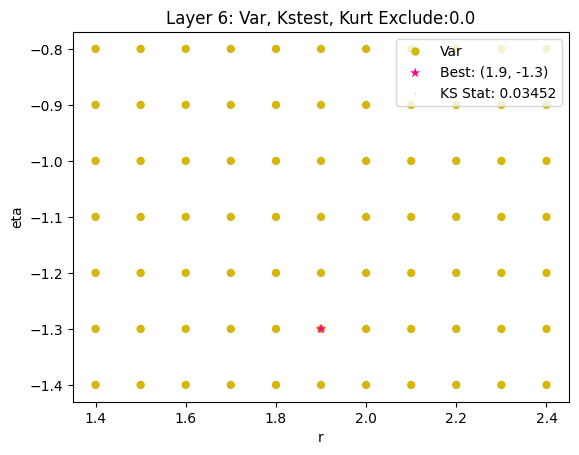

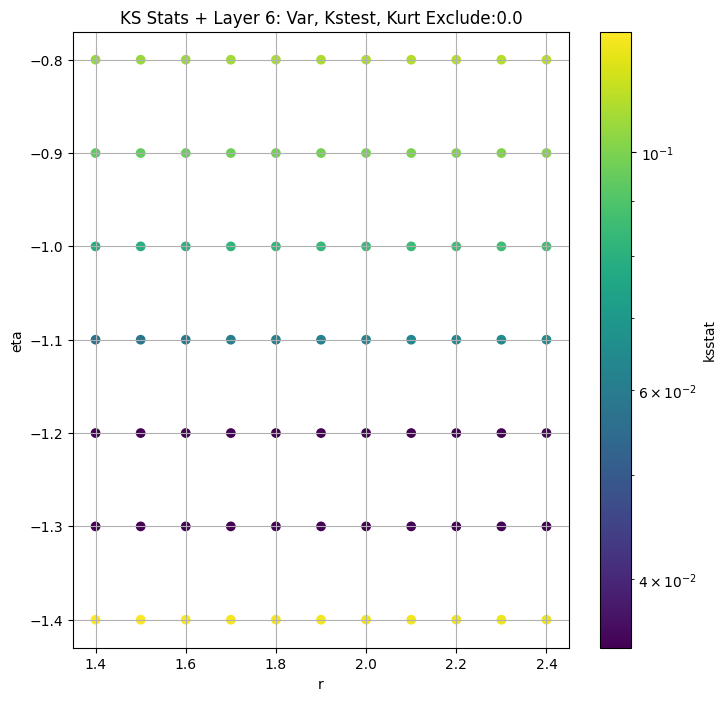

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.07119999999999976 2.3220341


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.07119999999999976 2.231028


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.07119999999999976 2.172821


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.07119999999999976 2.124171


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.07119999999999976 2.0811656


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.07119999999999976 2.0059938


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.07119999999999976 1.940815


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.07119999999999976 1.8826978


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.07119999999999976 1.8299112


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.07119999999999976 1.7813935


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.07119999999999976 1.6548305
Number of samples: 100000, Without approximation : 7241728


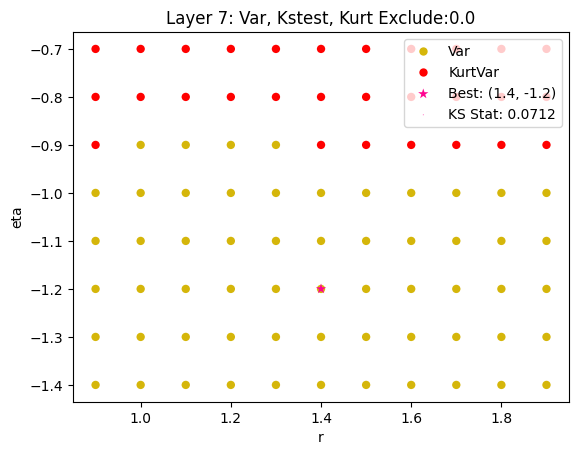

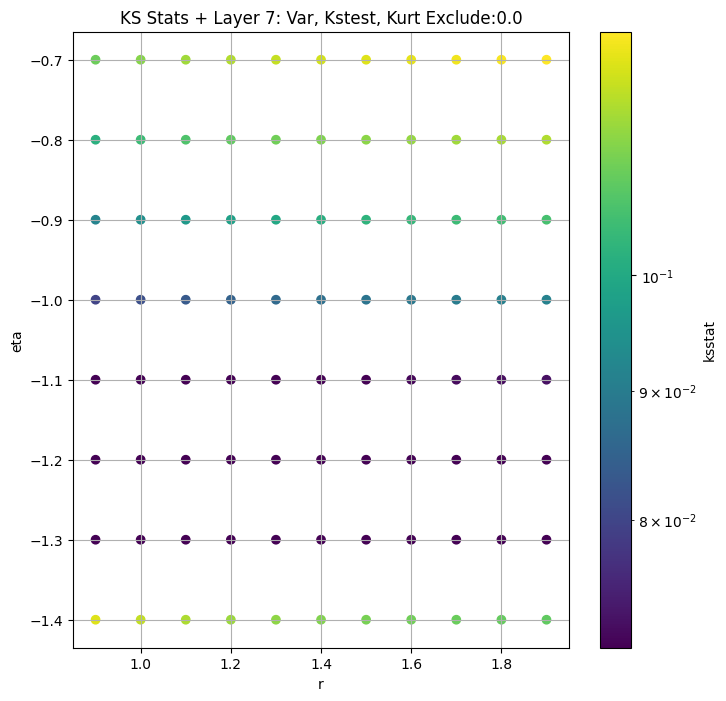

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.11883999999999972 0.5561962


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.11883999999999972 0.53141505


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.11883999999999972 0.5167572


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.11883999999999972 0.50460064


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.11883999999999972 0.49391255


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.11883999999999972 0.47540152


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.11883999999999972 0.45947462


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.11883999999999972 0.44534335


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.11883999999999972 0.4325637


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.11883999999999972 0.42086434


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.11883999999999972 0.39060003
Number of samples: 100000, Without approximation : 28966912


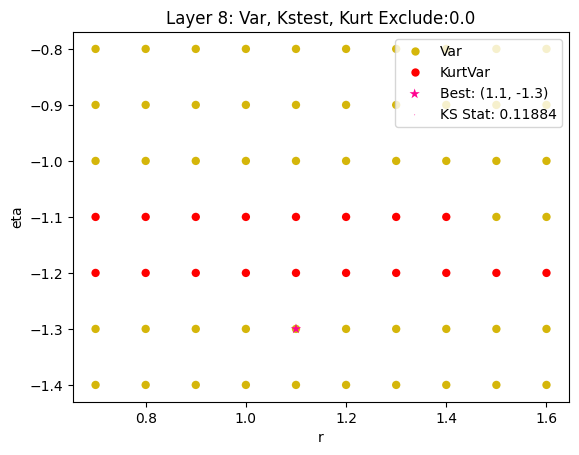

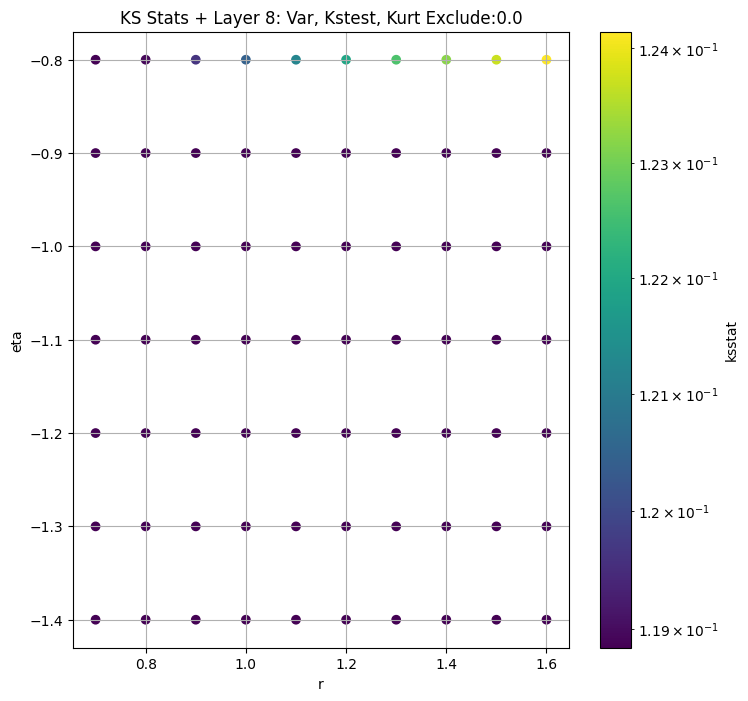

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.16923999999999972 0.1654709


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.16923999999999972 0.15816279


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.16923999999999972 0.15394542


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.16923999999999972 0.15047315


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.16923999999999972 0.1474455


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.16923999999999972 0.1422446


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.16923999999999972 0.13780263


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.16923999999999972 0.13388534


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.16923999999999972 0.13036044


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.16923999999999972 0.1271454


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.16923999999999972 0.11886037
Number of samples: 100000, Without approximation : 115867648


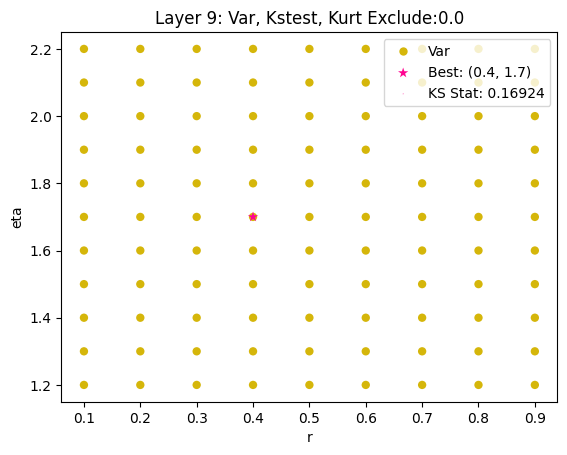

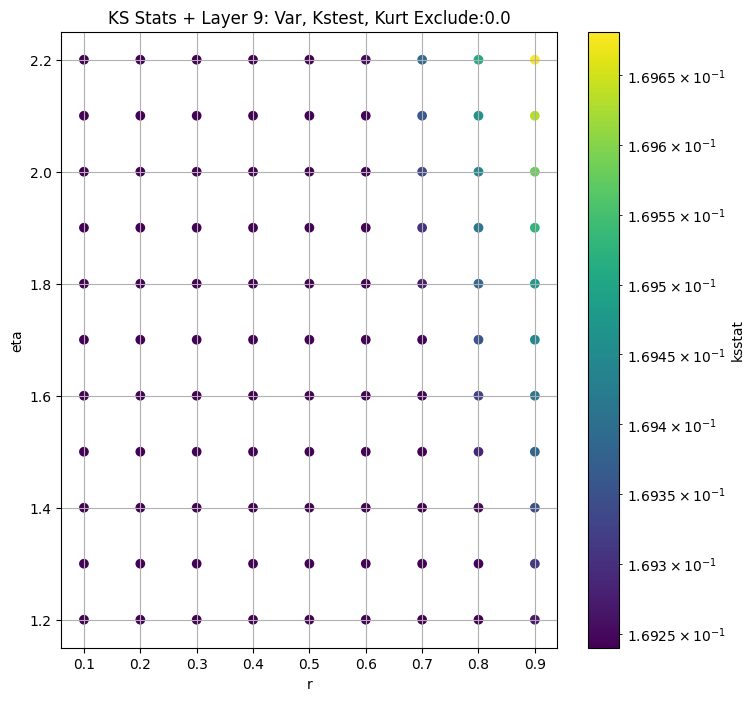

####
Layer  10


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 0 0.21863999999999972 0.071799554


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 25 0.21863999999999972 0.06904248


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 50 0.21863999999999972 0.0675052


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 75 0.21863999999999972 0.066258416


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 100 0.21863999999999972 0.06518212


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 150 0.21863999999999972 0.06335359


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 200 0.21863999999999972 0.061809883


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 250 0.21863999999999972 0.0604592


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 300 0.21863999999999972 0.05925024


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 350 0.21863999999999972 0.0581506


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 500 0.21863999999999972 0.05531936
Number of samples: 100000, Without approximation : 463470592


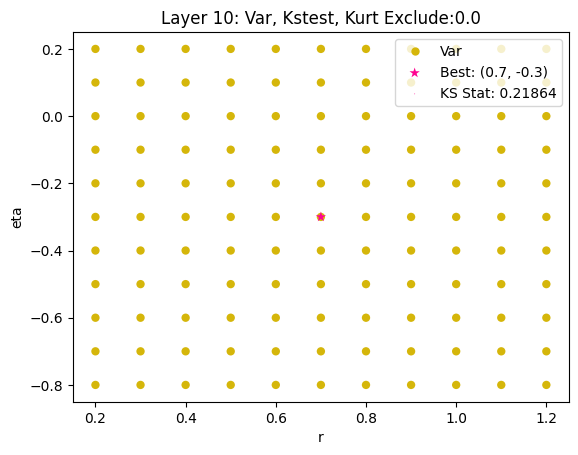

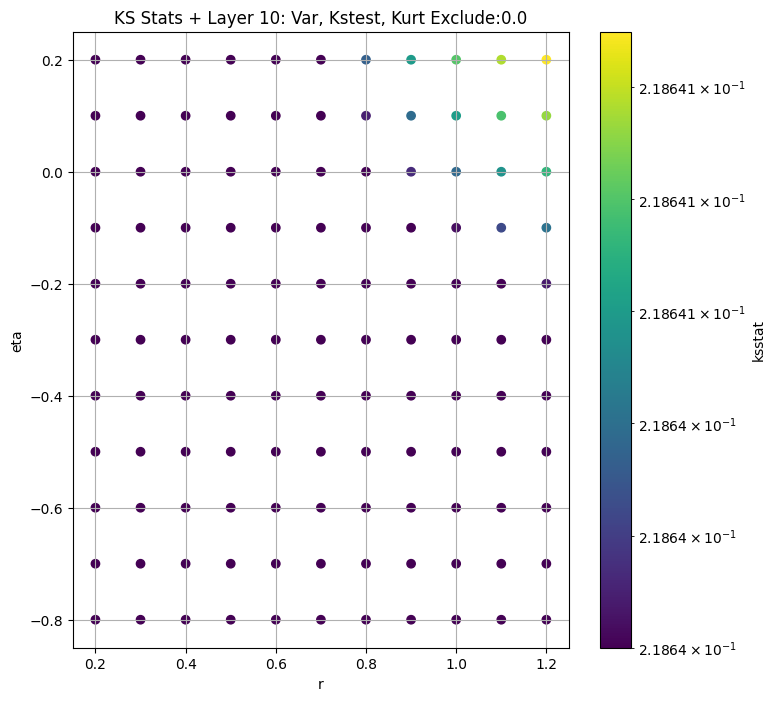

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      2992.346700  2795.771000  3197.442000   2.840140    2.327932   
3       780.423100   728.603940   834.956850   4.924683    3.954512   
4       197.344920   182.717960   212.721620   6.607422    5.379036   
5        45.919570    42.290737    49.782864   8.213636    6.600699   
6        10.315014     9.406057    11.280571  10.381206    8.092984   
7         2.322034     2.104991     2.558147  12.456102    9.404761   
8         0.556196     0.501761     0.618983  14.527348    9.739854   
9         0.165471     0.149907     0.183561  13.340412    8.399303   
10        0.071800     0.066021     0.078448   9.116372    5.449671   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        3.407406           7072             0.010219        9.3         -0.9   
3        6.222755          28288             0.005118        5.4         -1.1   
4        8.421290         113152             0.007230        8.6         -1.2   
5       10.661204         452608             0.013694        0.8         -1.2   
6       14.631648        1810432             0.034520        1.9         -1.3   
7       19.237617        7241728             0.071200        1.4         -1.2   
8       34.173534       28966912             0.118840        1.1         -1.3   
9       32.501076      115867648             0.169240        0.4          1.7   
10      21.428100      463470592             0.218640        0.7         -0.3   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2        7369.889380                    25.0         2647.723600   
3        2635.649290                    50.0          707.823060   
4         835.297317                   100.0          183.256090   
5         117.887420                    25.0           44.588768   
6          65.461617                     0.0           10.315014   
7           9.468160                     0.0            2.322034   
8           2.956975                     0.0            0.556196   
9           0.000736                     0.0            0.165471   
10          0.028566                     0.0            0.071800   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.016126  
3                     0.008069  
4                     0.004036  
5                     0.002018  
6                     0.001009  
7                     0.000505  
8                     0.000252  
9                     0.000126  
10                    0.000063

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/180 [00:00<?, ?it/s]

Finding Minimum after computing 180 CDFs
layer 2, 25.0 + 100 = 125, ksstat: 0.025892094557835366, var: 1992.525390625


  0%|          | 0/180 [00:00<?, ?it/s]

Finding Minimum after computing 180 CDFs
layer 2, 25.0 + 75 = 100, ksstat: 0.02178715661461883, var: 2115.781982421875


  0%|          | 0/180 [00:00<?, ?it/s]

Finding Minimum after computing 180 CDFs
layer 2, 25.0 + 50 = 75, ksstat: 0.017318390329679967, var: 2259.61474609375


  0%|          | 0/180 [00:00<?, ?it/s]

Finding Minimum after computing 180 CDFs
layer 2, 25.0 + 25 = 50, ksstat: 0.012665853587037645, var: 2431.564453125


  0%|          | 0/180 [00:00<?, ?it/s]

Finding Minimum after computing 180 CDFs
layer 2, 25.0 + 0 = 25, ksstat: 0.010218928617440282, var: 2647.7236328125


  0%|          | 0/180 [00:00<?, ?it/s]

Finding Minimum after computing 180 CDFs
layer 2, 25.0 + -25 = 0, ksstat: 0.013033951933900445, var: 2992.3466796875
Number of samples: 7072, Without approximation : 7072


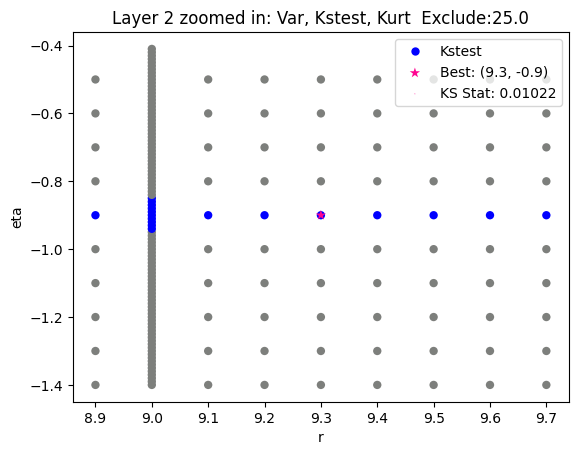

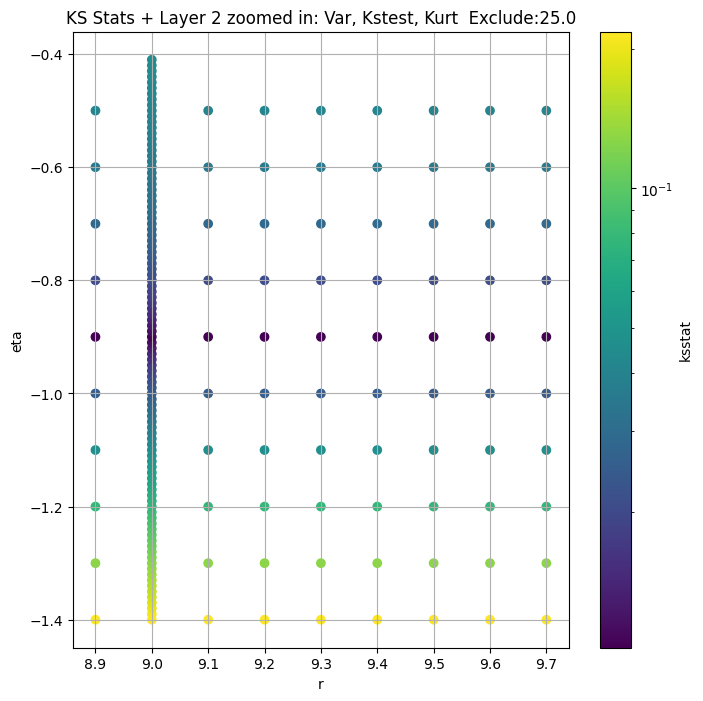

Layer 3


  0%|          | 0/149 [00:00<?, ?it/s]

Finding Minimum after computing 149 CDFs
layer 3, 50.0 + 100 = 150, ksstat: 0.00926560874209275, var: 628.7913208007812


  0%|          | 0/149 [00:00<?, ?it/s]

Finding Minimum after computing 149 CDFs
layer 3, 50.0 + 75 = 125, ksstat: 0.00815809281453879, var: 645.3074340820312


  0%|          | 0/149 [00:00<?, ?it/s]

Finding Minimum after computing 149 CDFs
layer 3, 50.0 + 50 = 100, ksstat: 0.0072306997619383424, var: 663.3176879882812


  0%|          | 0/149 [00:00<?, ?it/s]

Finding Minimum after computing 149 CDFs
layer 3, 50.0 + 25 = 75, ksstat: 0.0060652582847850744, var: 684.0439453125


  0%|          | 0/149 [00:00<?, ?it/s]

Finding Minimum after computing 149 CDFs
layer 3, 50.0 + 0 = 50, ksstat: 0.0051181059868768974, var: 707.8230590820312


  0%|          | 0/149 [00:00<?, ?it/s]

Finding Minimum after computing 149 CDFs
layer 3, 50.0 + -25 = 25, ksstat: 0.006475461026223539, var: 736.478515625


  0%|          | 0/149 [00:00<?, ?it/s]

Finding Minimum after computing 149 CDFs
layer 3, 50.0 + -50 = 0, ksstat: 0.009256004817065427, var: 780.423095703125
Number of samples: 28288, Without approximation : 28288


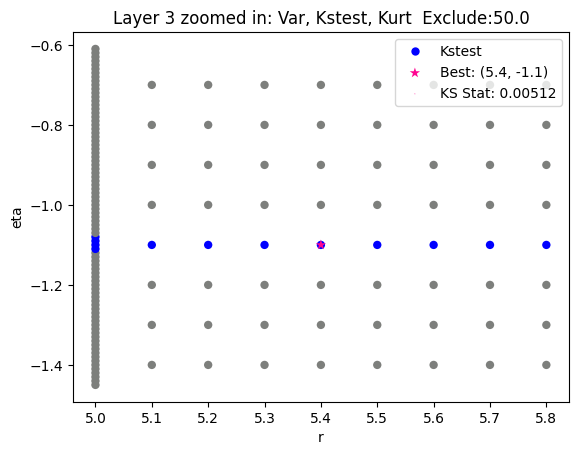

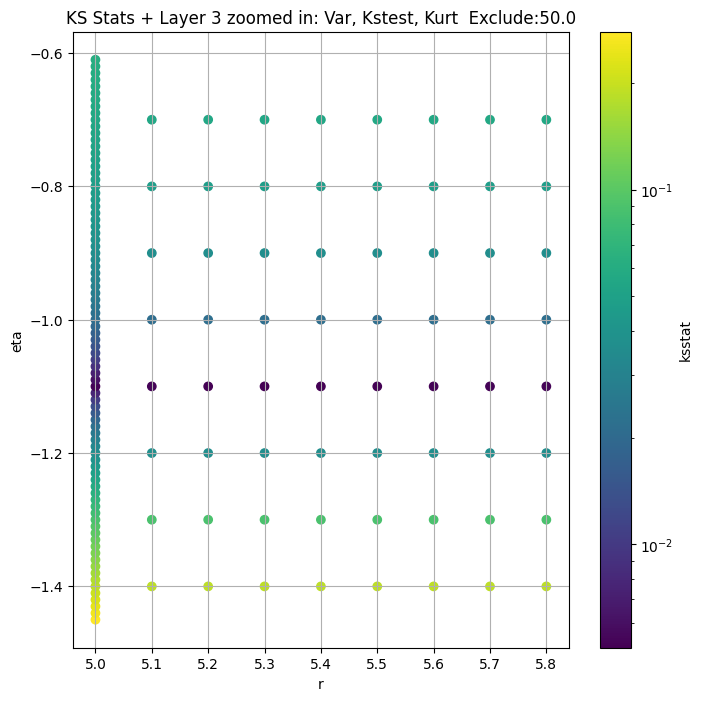

Layer 4


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 4, 100.0 + 100 = 200, ksstat: 0.007688853807613971, var: 174.21681213378906


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 4, 100.0 + 75 = 175, ksstat: 0.00770645121203084, var: 176.27023315429688


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 4, 100.0 + 50 = 150, ksstat: 0.007724681232329944, var: 178.4356231689453


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 4, 100.0 + 25 = 125, ksstat: 0.007635806904988385, var: 180.76182556152344


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 4, 100.0 + 0 = 100, ksstat: 0.007230081087759577, var: 183.25608825683594


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 4, 100.0 + -25 = 75, ksstat: 0.008115496164479152, var: 185.9717559814453


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 4, 100.0 + -50 = 50, ksstat: 0.009152062552373885, var: 188.993408203125


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 4, 100.0 + -75 = 25, ksstat: 0.009634909667241731, var: 192.48306274414062


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 4, 100.0 + -100 = 0, ksstat: 0.010057166303915843, var: 197.3449249267578
Number of samples: 100000, Without approximation : 113152


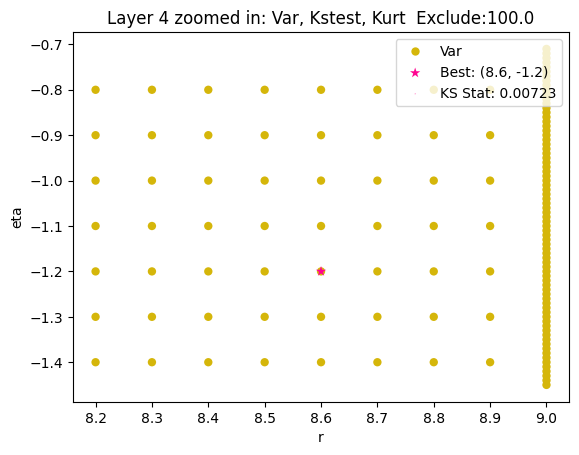

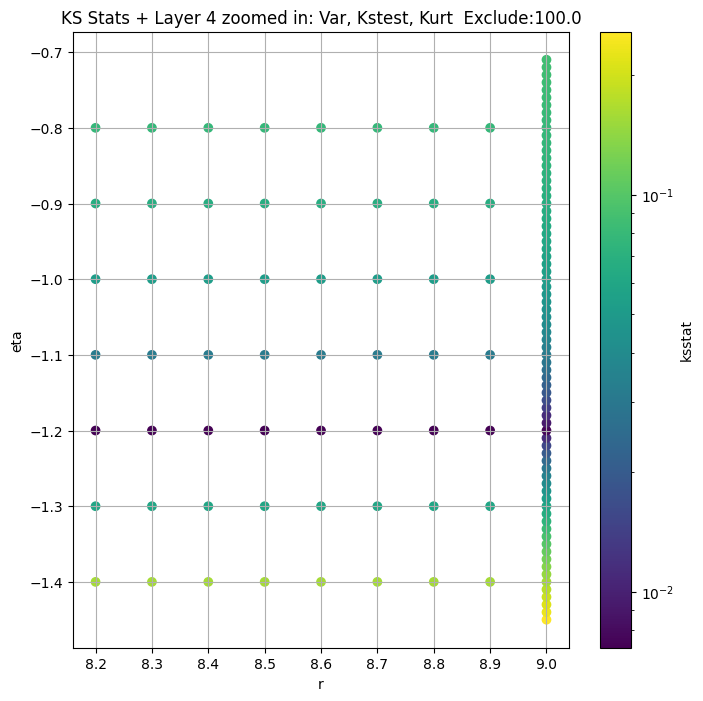

Layer 5


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 5, 25.0 + 100 = 125, ksstat: 0.013693581323313775, var: 41.588623046875


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 5, 25.0 + 75 = 100, ksstat: 0.013693586676346292, var: 42.22478103637695


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 5, 25.0 + 50 = 75, ksstat: 0.013689999999999924, var: 42.921775817871094


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 5, 25.0 + 25 = 50, ksstat: 0.013689999999999924, var: 43.68954086303711


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 5, 25.0 + 0 = 25, ksstat: 0.013689999999999924, var: 44.588768005371094


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 5, 25.0 + -25 = 0, ksstat: 0.013689999999999813, var: 45.91957092285156
Number of samples: 100000, Without approximation : 452608


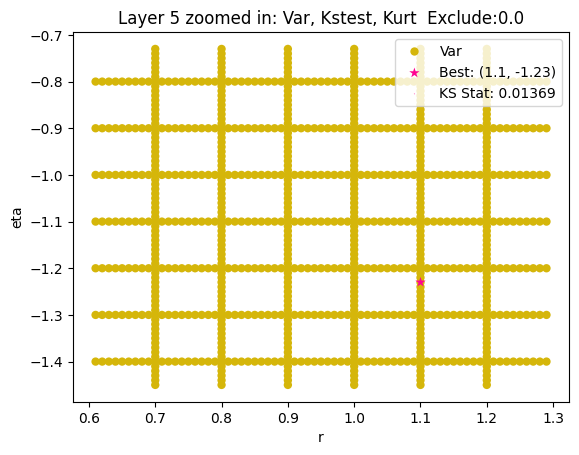

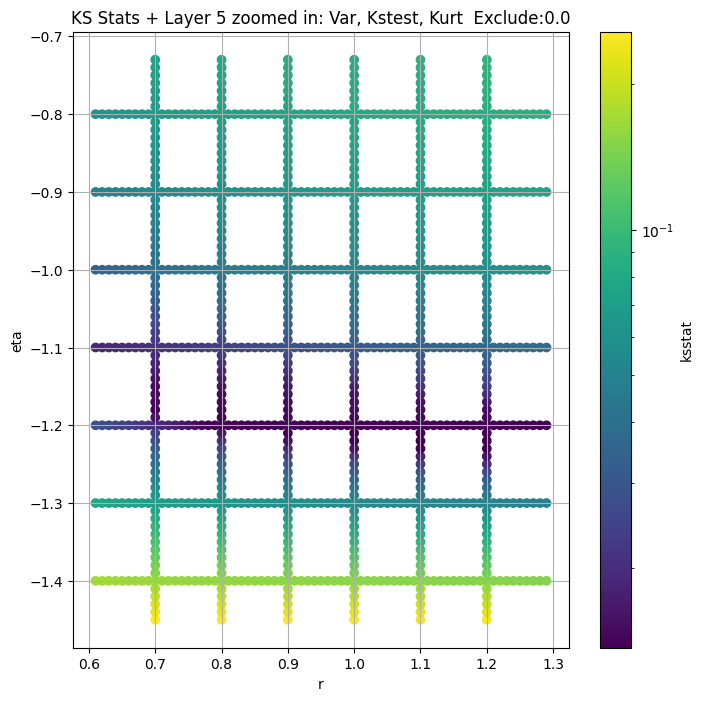

Layer 6


  0%|          | 0/732 [00:00<?, ?it/s]

Finding Minimum after computing 732 CDFs
layer 6, 0.0 + 100 = 100, ksstat: 0.03451999999999977, var: 9.356100082397461


  0%|          | 0/732 [00:00<?, ?it/s]

Finding Minimum after computing 732 CDFs
layer 6, 0.0 + 75 = 75, ksstat: 0.03451999999999977, var: 9.530621528625488


  0%|          | 0/732 [00:00<?, ?it/s]

Finding Minimum after computing 732 CDFs
layer 6, 0.0 + 50 = 50, ksstat: 0.03451999999999977, var: 9.727058410644531


  0%|          | 0/732 [00:00<?, ?it/s]

Finding Minimum after computing 732 CDFs
layer 6, 0.0 + 25 = 25, ksstat: 0.03451999999999977, var: 9.959997177124023


  0%|          | 0/732 [00:00<?, ?it/s]

Finding Minimum after computing 732 CDFs
layer 6, 0.0 + 0 = 0, ksstat: 0.03451999999999977, var: 10.315013885498047
Number of samples: 100000, Without approximation : 1810432


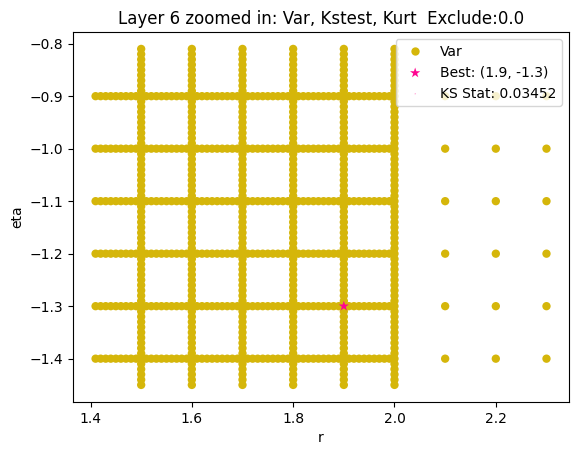

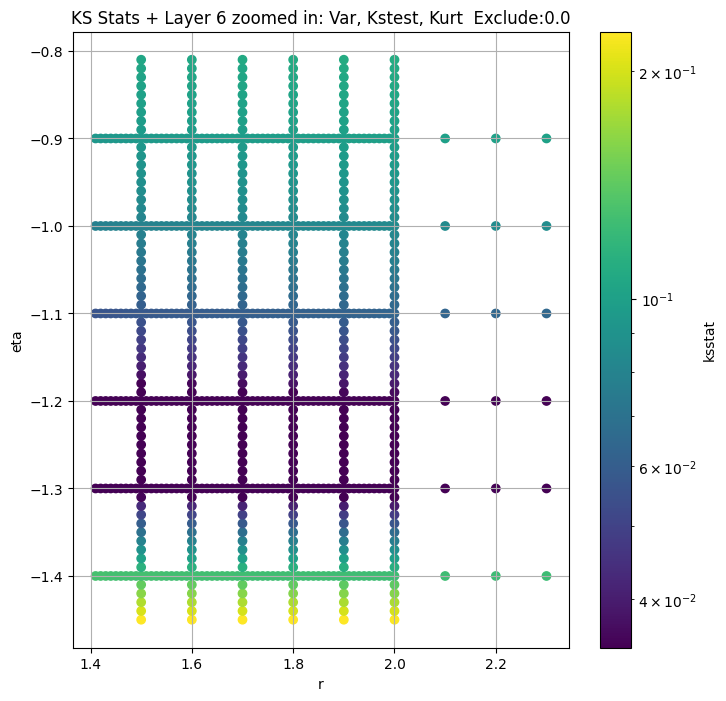

Layer 7


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 0.0 + 100 = 100, ksstat: 0.07119999999999971, var: 2.0811655521392822


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 0.0 + 75 = 75, ksstat: 0.07119999999999971, var: 2.124171018600464


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 0.0 + 50 = 50, ksstat: 0.07119999999999971, var: 2.172821044921875


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 0.0 + 25 = 25, ksstat: 0.07119999999999971, var: 2.2310280799865723


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 7, 0.0 + 0 = 0, ksstat: 0.07119999999999971, var: 2.3220341205596924
Number of samples: 100000, Without approximation : 7241728


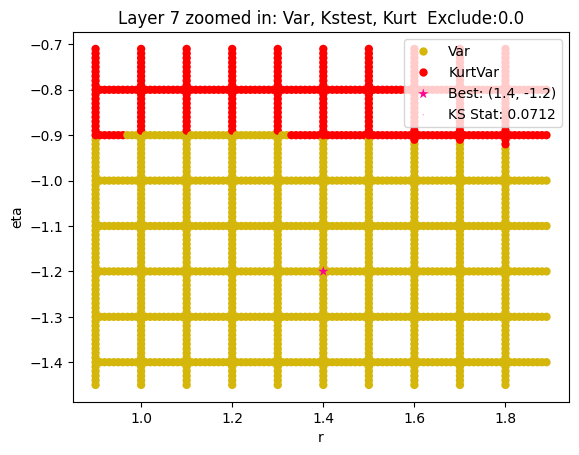

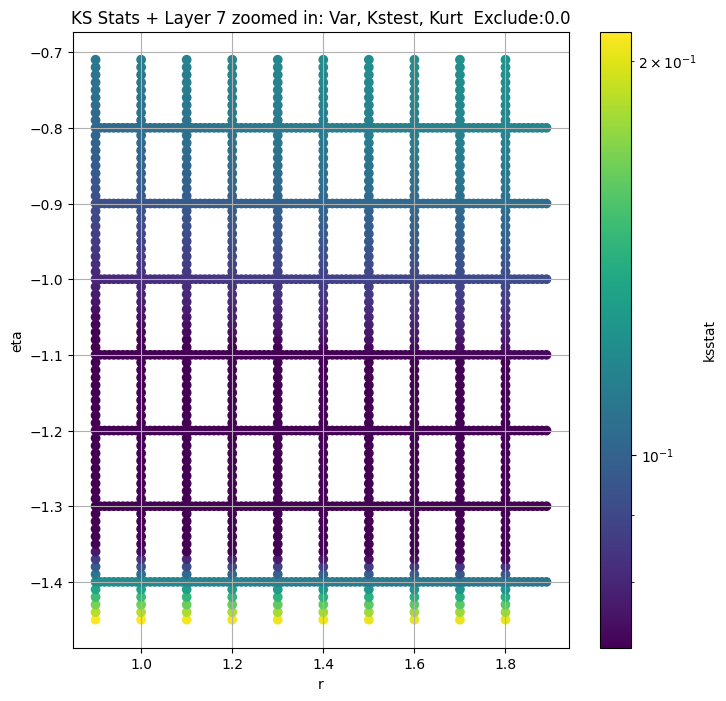

Layer 8


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 8, 0.0 + 100 = 100, ksstat: 0.11883999999999972, var: 0.49391254782676697


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 8, 0.0 + 75 = 75, ksstat: 0.11883999999999972, var: 0.5046006441116333


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 8, 0.0 + 50 = 50, ksstat: 0.11883999999999972, var: 0.5167571902275085


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 8, 0.0 + 25 = 25, ksstat: 0.11883999999999972, var: 0.5314150452613831


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 8, 0.0 + 0 = 0, ksstat: 0.11883999999999972, var: 0.5561962127685547
Number of samples: 100000, Without approximation : 28966912


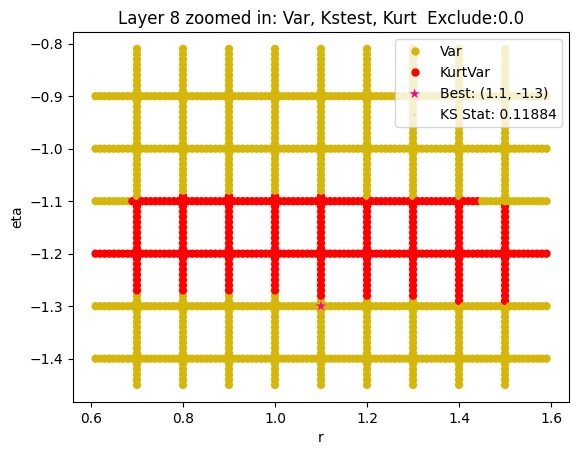

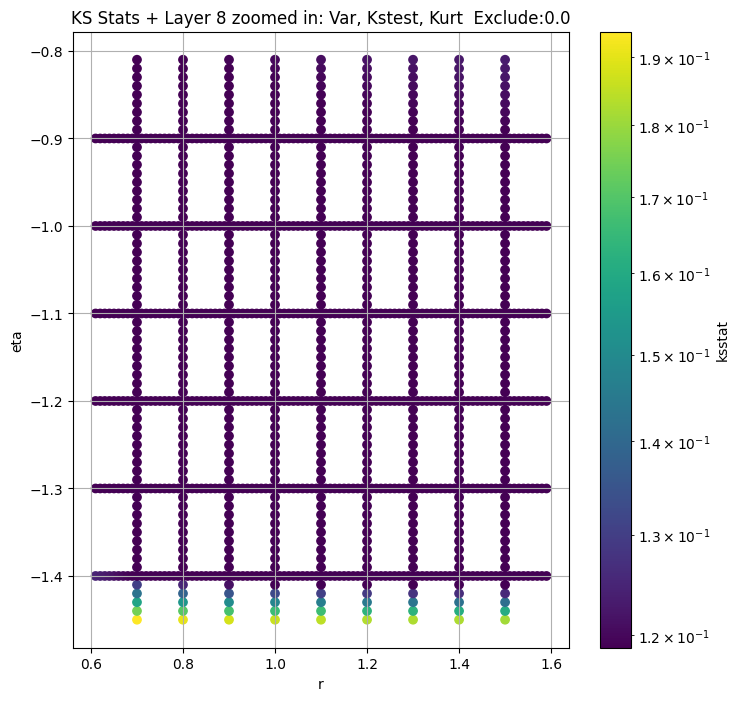

Layer 9


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 9, 0.0 + 100 = 100, ksstat: 0.16923999999999972, var: 0.14744549989700317


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 9, 0.0 + 75 = 75, ksstat: 0.16923999999999972, var: 0.15047314763069153


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 9, 0.0 + 50 = 50, ksstat: 0.16923999999999972, var: 0.1539454162120819


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 9, 0.0 + 25 = 25, ksstat: 0.16923999999999972, var: 0.15816278755664825


  0%|          | 0/792 [00:00<?, ?it/s]

Finding Minimum after computing 792 CDFs
layer 9, 0.0 + 0 = 0, ksstat: 0.16923999999999972, var: 0.1654708981513977
Number of samples: 100000, Without approximation : 115867648


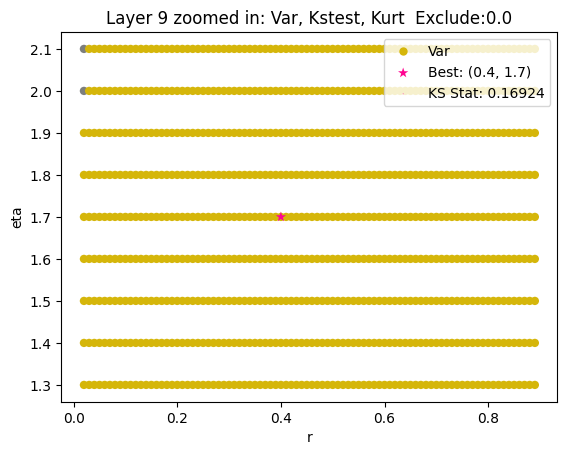

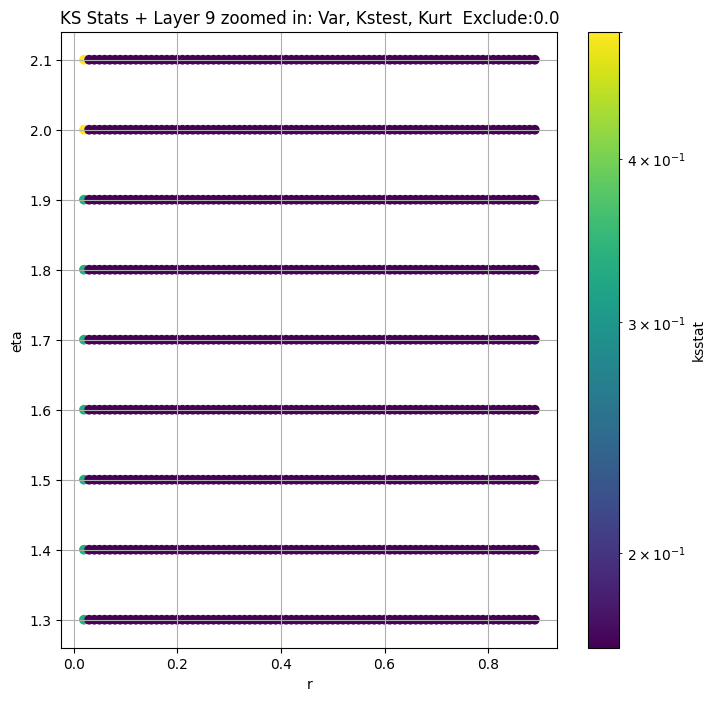

Layer 10


  0%|          | 0/1620 [00:00<?, ?it/s]

Finding Minimum after computing 1620 CDFs
layer 10, 0.0 + 100 = 100, ksstat: 0.21863999999999972, var: 0.06518211960792542


  0%|          | 0/1620 [00:00<?, ?it/s]

Finding Minimum after computing 1620 CDFs
layer 10, 0.0 + 75 = 75, ksstat: 0.21863999999999972, var: 0.06625841557979584


  0%|          | 0/1620 [00:00<?, ?it/s]

Finding Minimum after computing 1620 CDFs
layer 10, 0.0 + 50 = 50, ksstat: 0.21863999999999972, var: 0.06750520318746567


  0%|          | 0/1620 [00:00<?, ?it/s]

Finding Minimum after computing 1620 CDFs
layer 10, 0.0 + 25 = 25, ksstat: 0.21863999999999972, var: 0.06904248148202896


  0%|          | 0/1620 [00:00<?, ?it/s]

Finding Minimum after computing 1620 CDFs
layer 10, 0.0 + 0 = 0, ksstat: 0.21863999999999972, var: 0.07179955393075943
Number of samples: 100000, Without approximation : 463470592


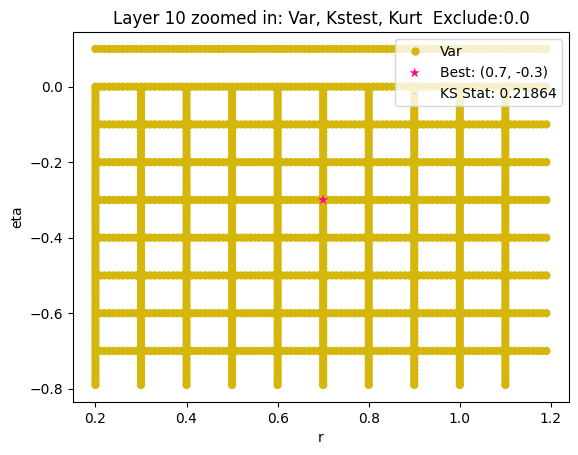

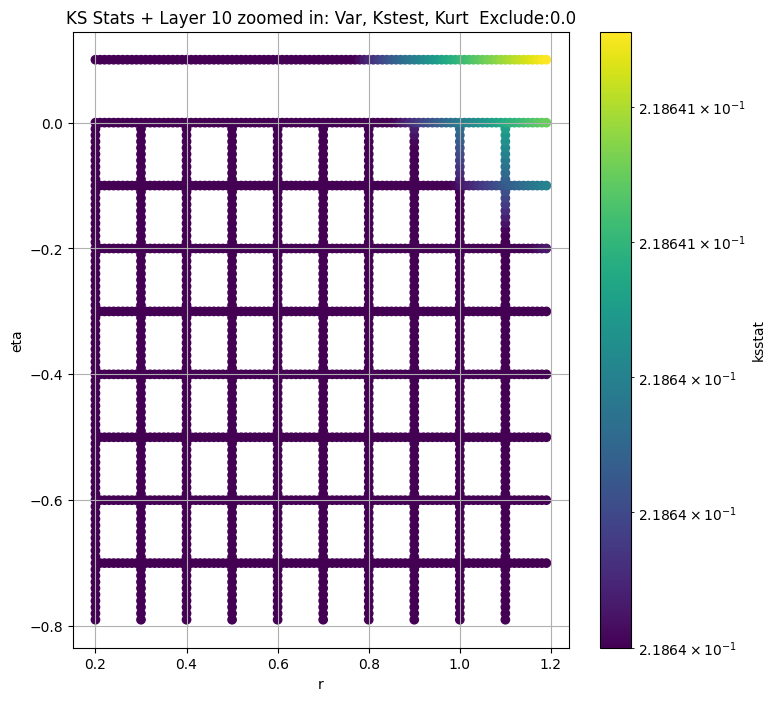

Not a fit


obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      2992.346700  2795.771000  3197.442000   2.840140    2.327932   
3       780.423100   728.603940   834.956850   4.924683    3.954512   
4       197.344920   182.717960   212.721620   6.607422    5.379036   
5        45.919570    42.290737    49.782864   8.213636    6.600699   
6        10.315014     9.406057    11.280571  10.381206    8.092984   
7         2.322034     2.104991     2.558147  12.456102    9.404761   
8         0.556196     0.501761     0.618983  14.527348    9.739854   
9         0.165471     0.149907     0.183561  13.340412    8.399303   
10        0.071800     0.066021     0.078448   9.116372    5.449671   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        3.407406           7072             0.010219        9.3         -0.9   
3        6.222755          28288             0.005118        5.4         -1.1   
4        8.421290         113152             0.007230        8.6         -1.2   
5       10.661204         452608             0.013694        0.8         -1.2   
6       14.631648        1810432             0.034520        1.9         -1.3   
7       19.237617        7241728             0.071200        1.4         -1.2   
8       34.173534       28966912             0.118840        1.1         -1.3   
9       32.501076      115867648             0.169240        0.4          1.7   
10      21.428100      463470592             0.218640        0.7         -0.3   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2        7369.889380                    25.0         2647.723600   
3        2635.649290                    50.0          707.823060   
4         835.297317                   100.0          183.256090   
5         117.887420                    25.0           45.919571   
6          65.461617                     0.0           10.315014   
7           9.468160                     0.0            2.322034   
8           2.956975                     0.0            0.556196   
9           0.000736                     0.0            0.165471   
10          0.028566                     0.0            0.071800   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.016126          0.010219     9.3     -0.90   
3                     0.008069          0.005118     5.4     -1.10   
4                     0.004036          0.007230     8.6     -1.20   
5                     0.002018          0.013690     1.1     -1.23   
6                     0.001009          0.034520     1.9     -1.30   
7                     0.000505          0.071200     1.4     -1.20   
8                     0.000252          0.118840     1.1     -1.30   
9                     0.000126          0.169240     0.4      1.70   
10                    0.000063          0.218640     0.7     -0.30   

        best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                 
2      7369.889380                 25.0        17901  
3      2635.649290                 50.0        71604  
4       835.297317                100.0        35802  
5       182.219545                  0.0        10068  
6        65.461617                  0.0         1491  
7         9.468160                  0.0          372  
8         2.956975                  0.0          123  
9         0.000736                  0.0           61  
10        0.028566                  0.0           -1

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

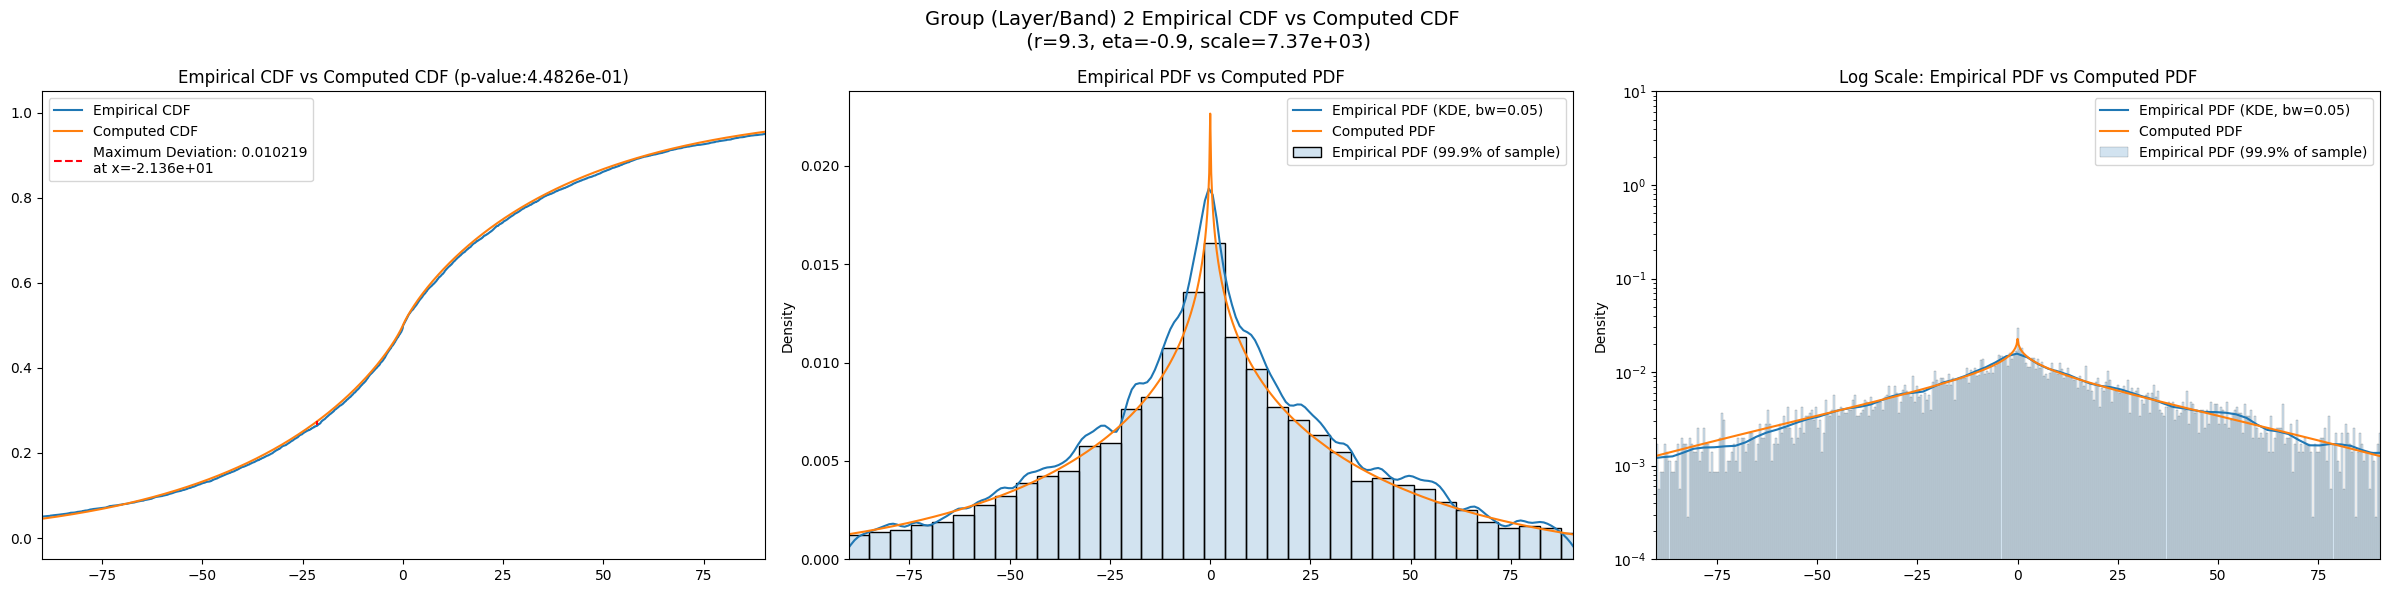

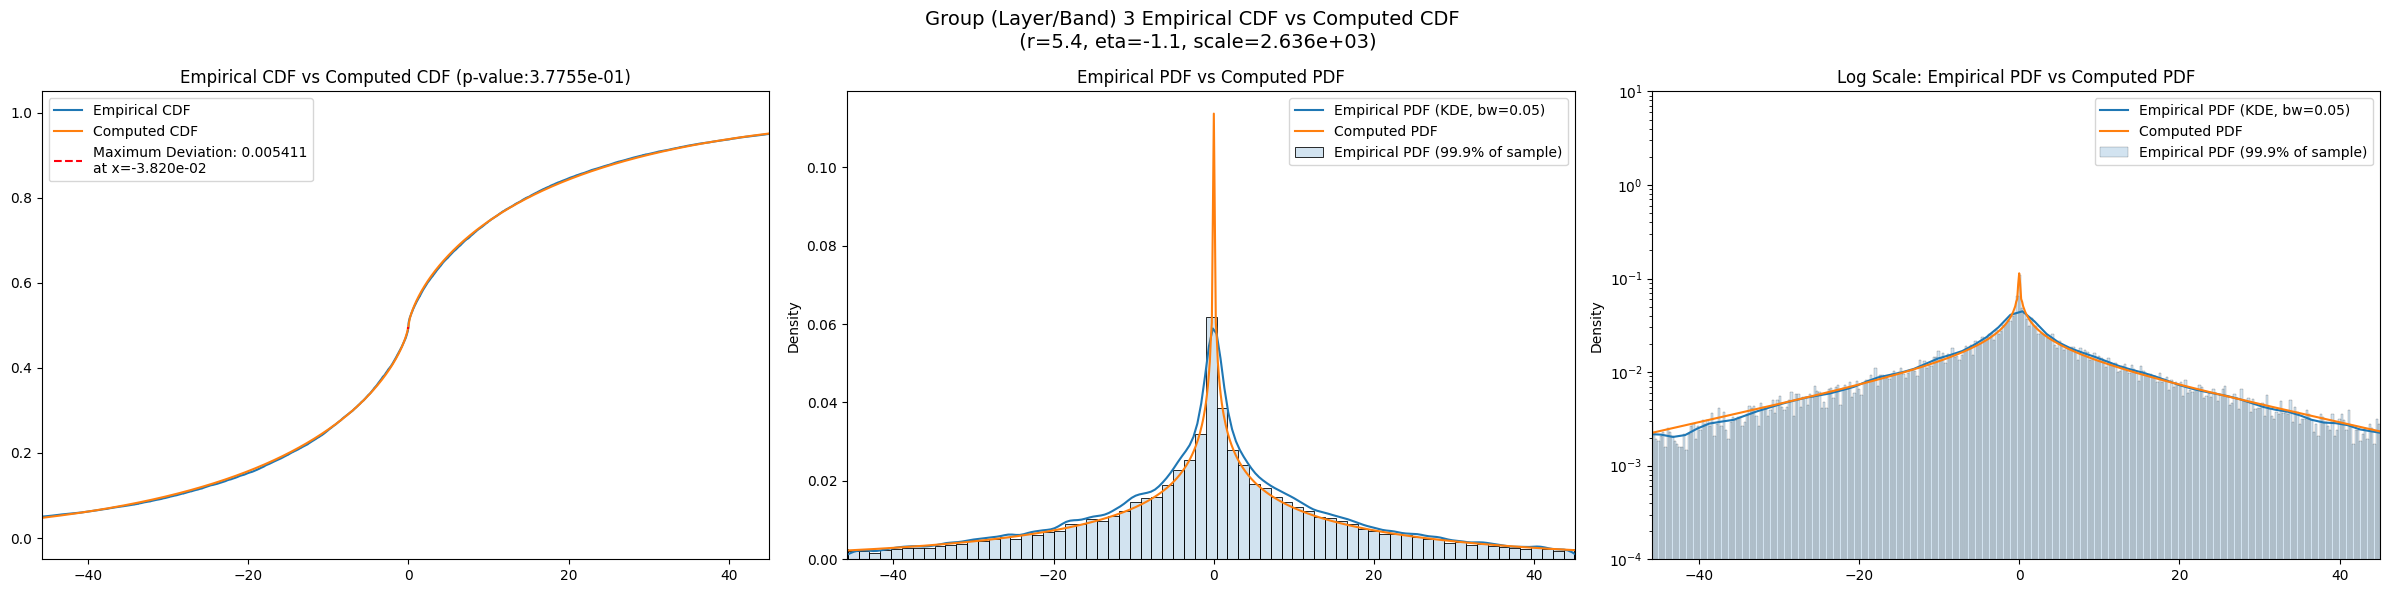

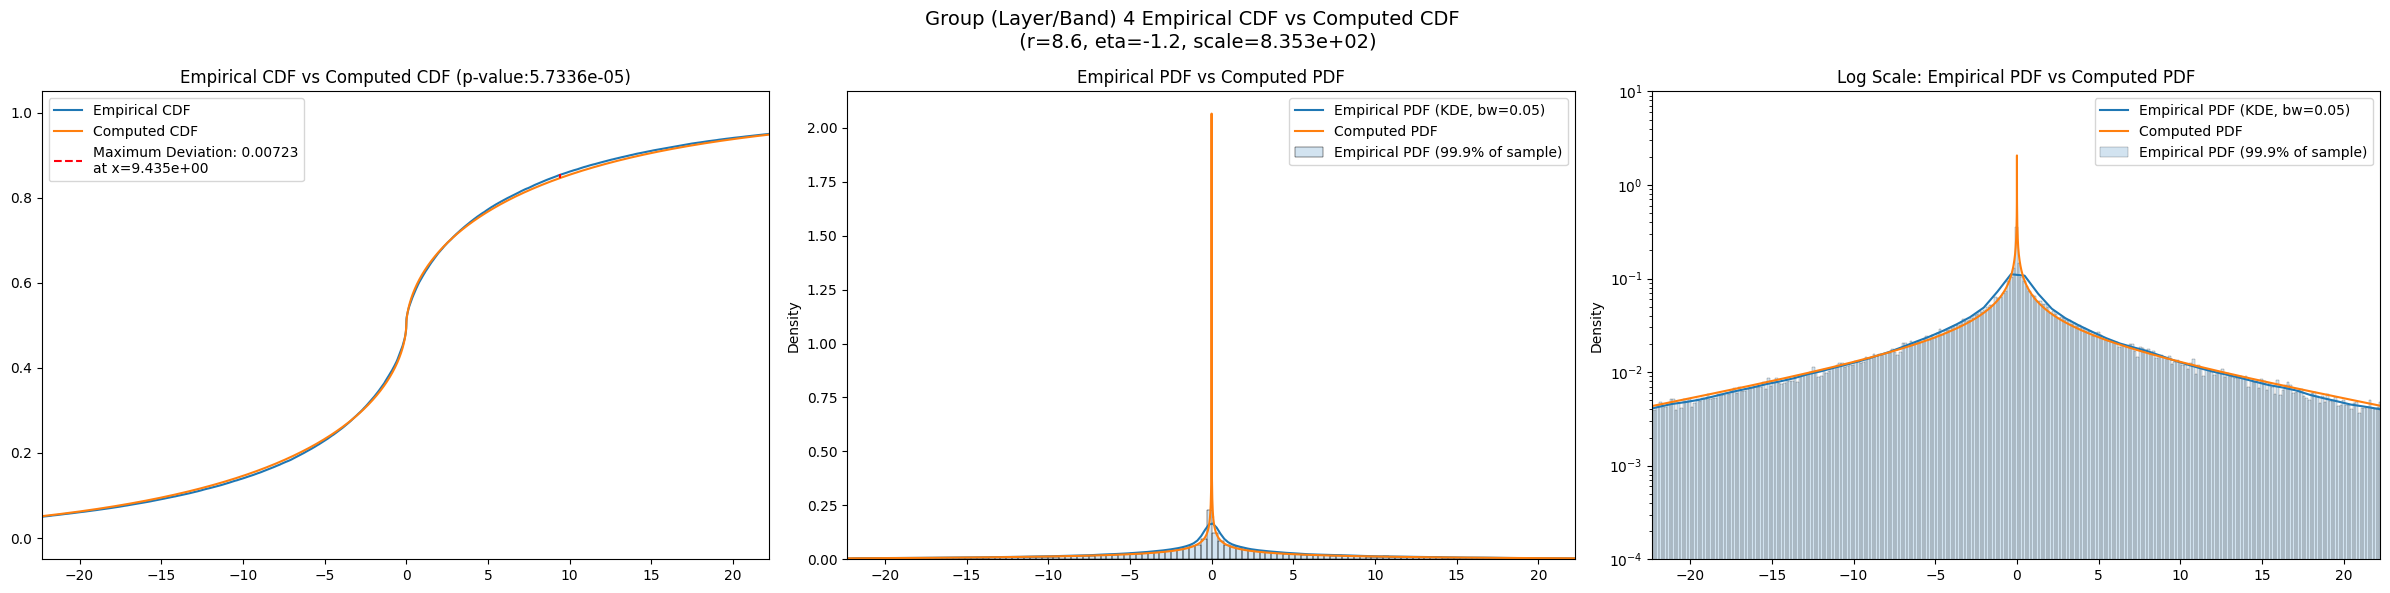

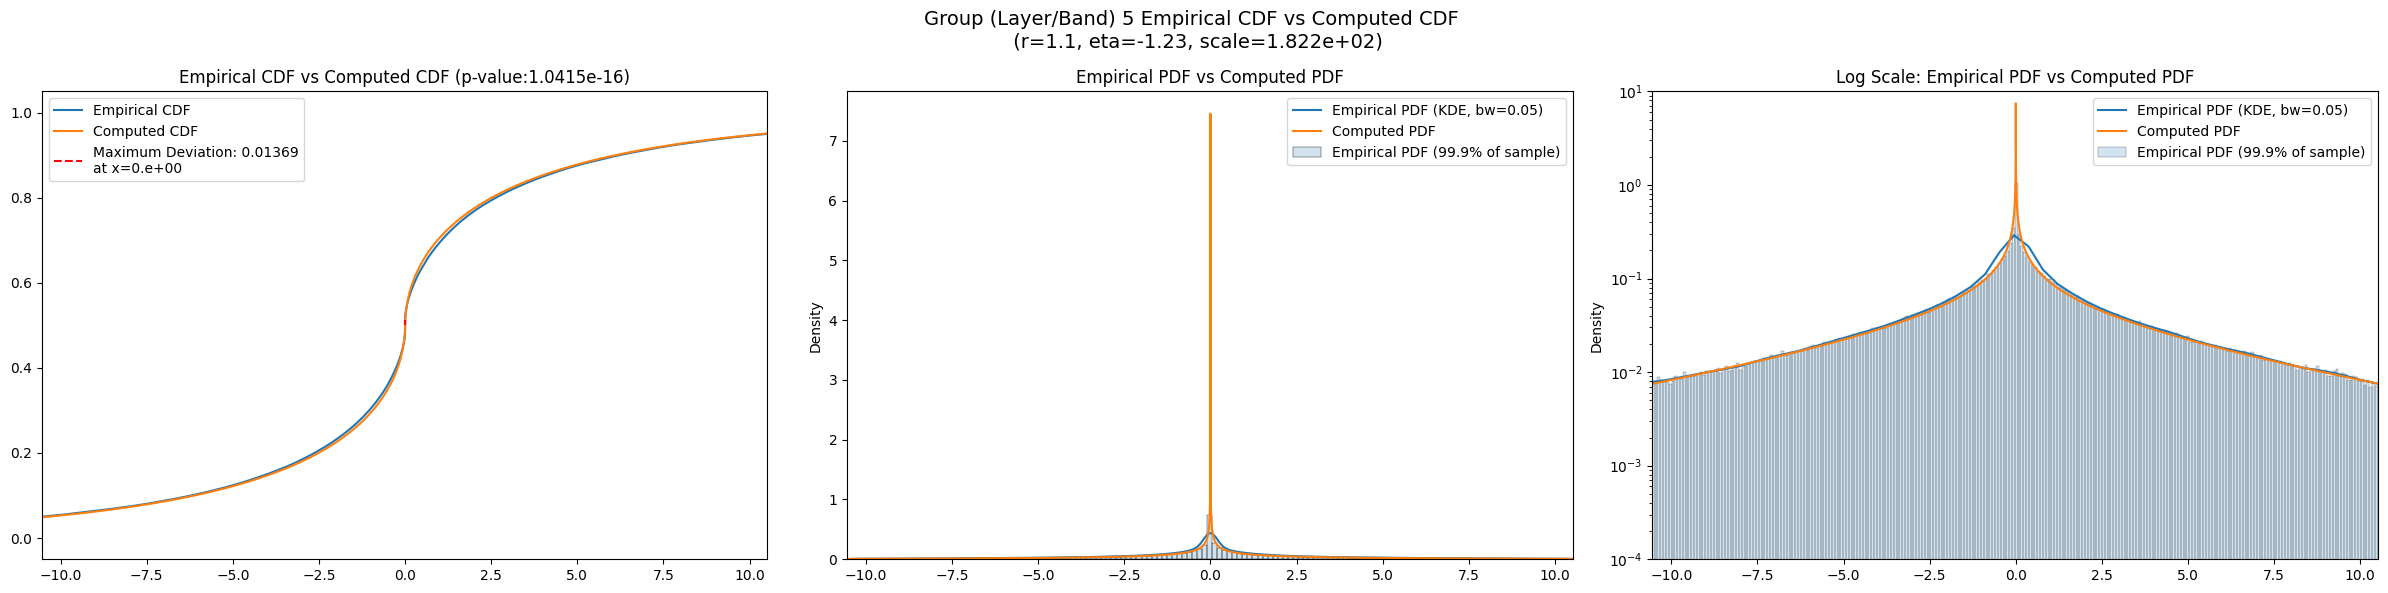

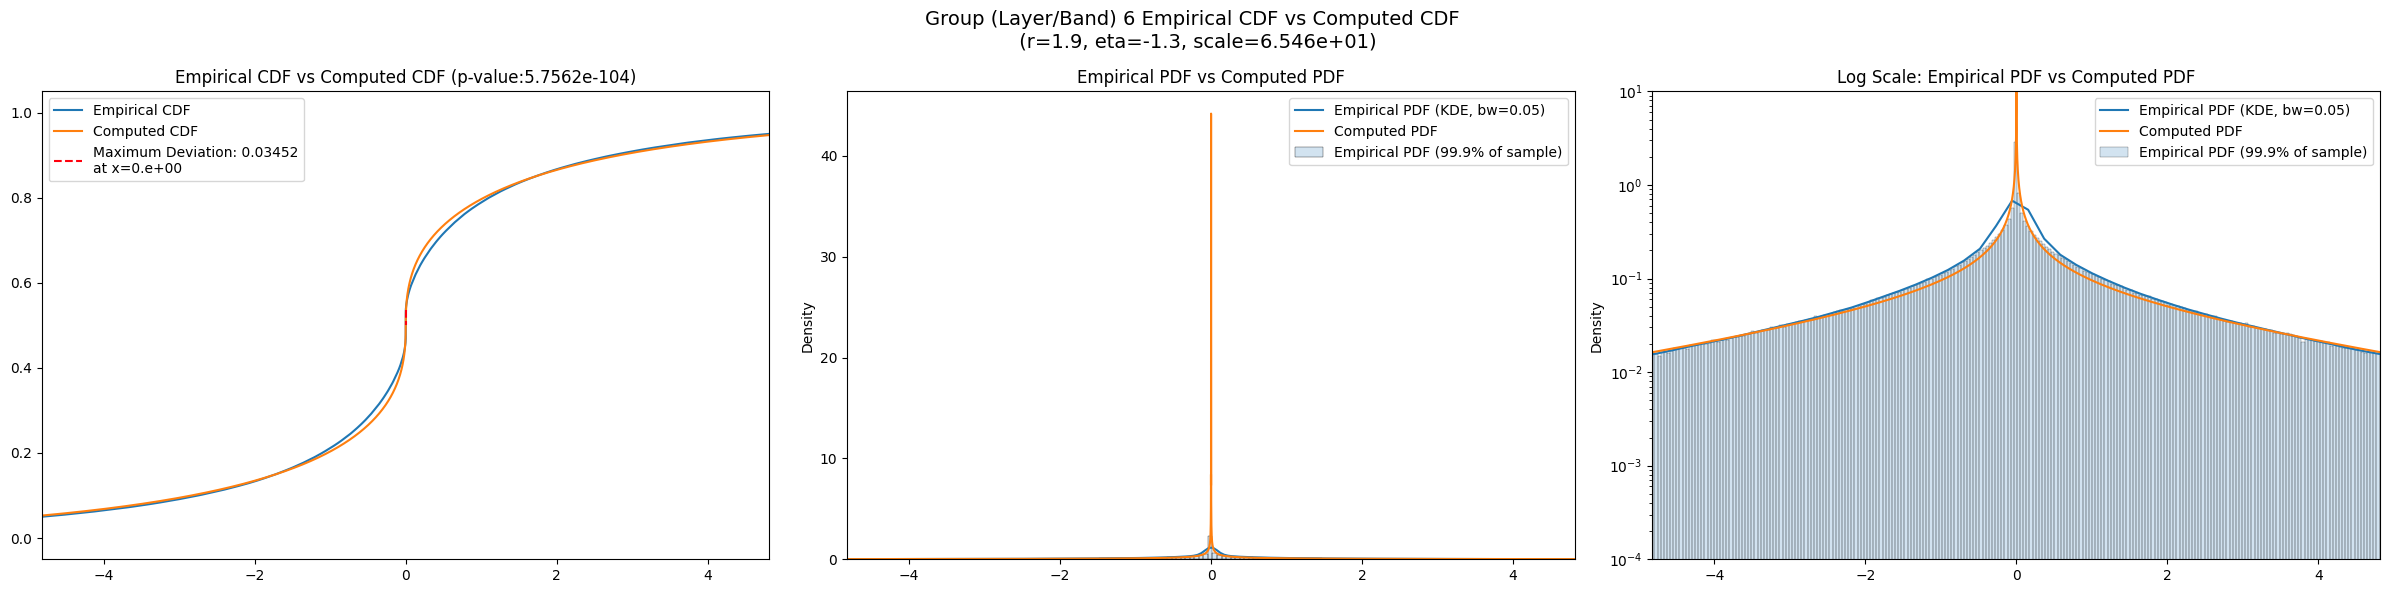

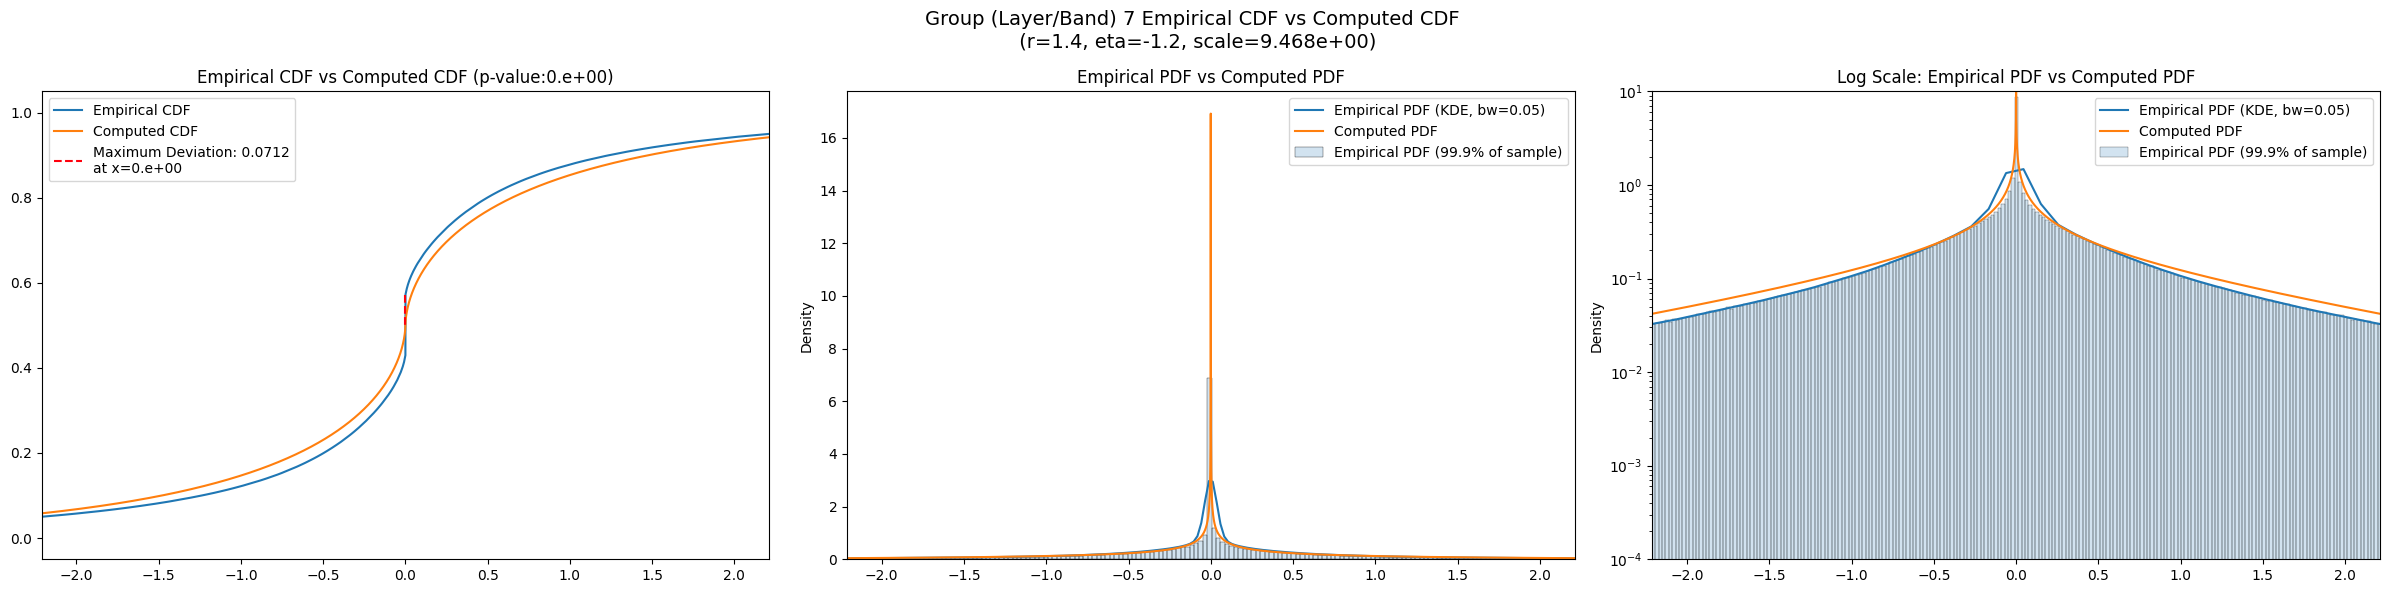

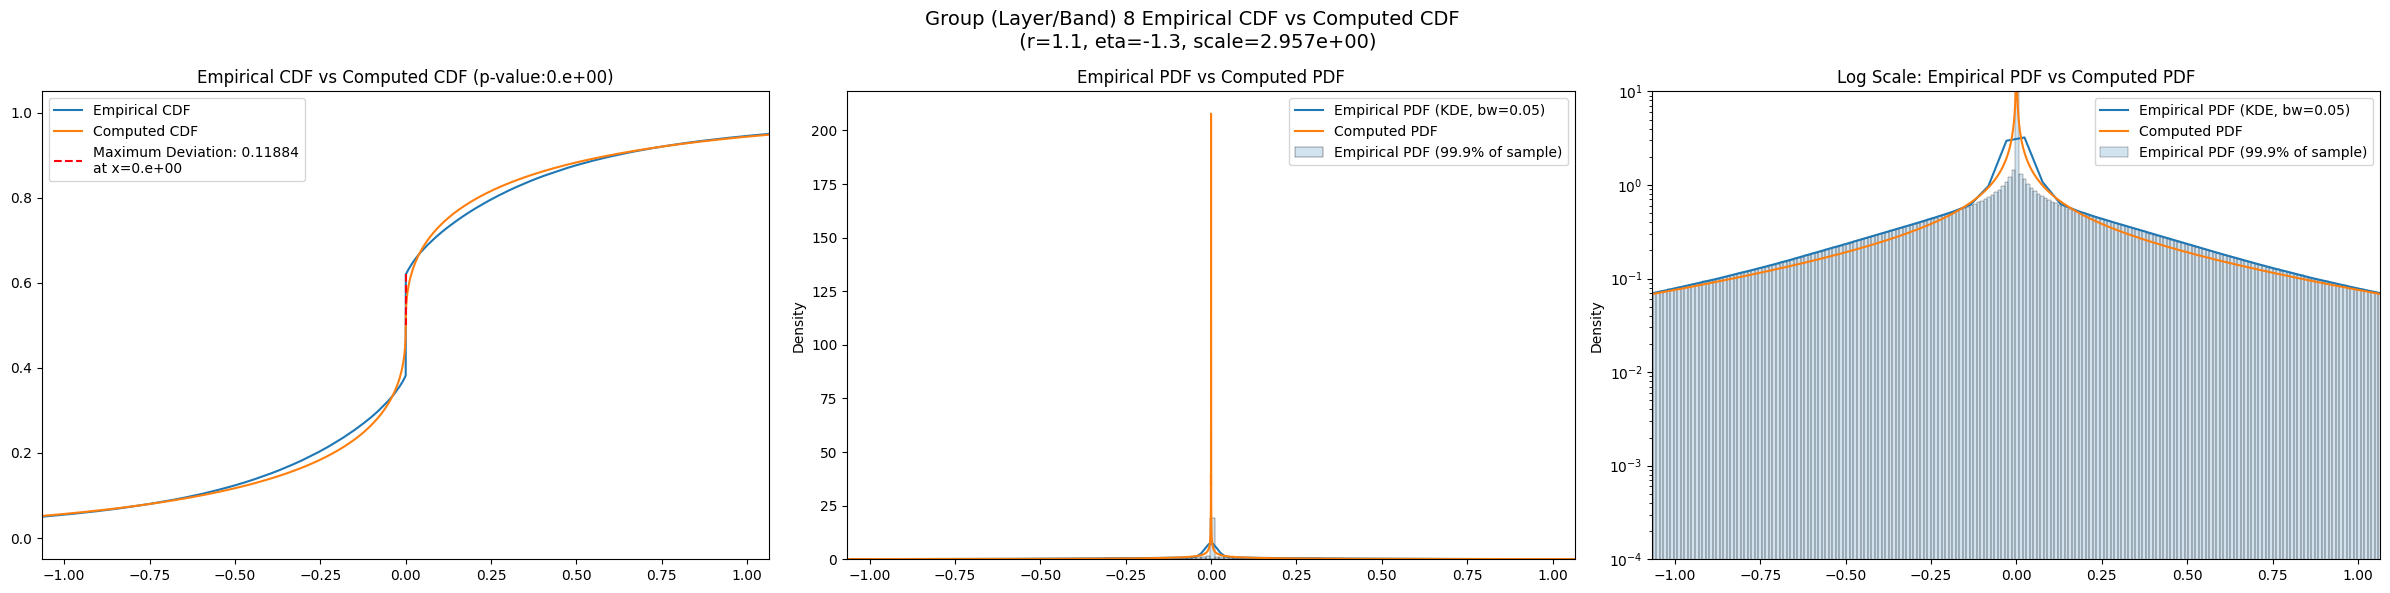

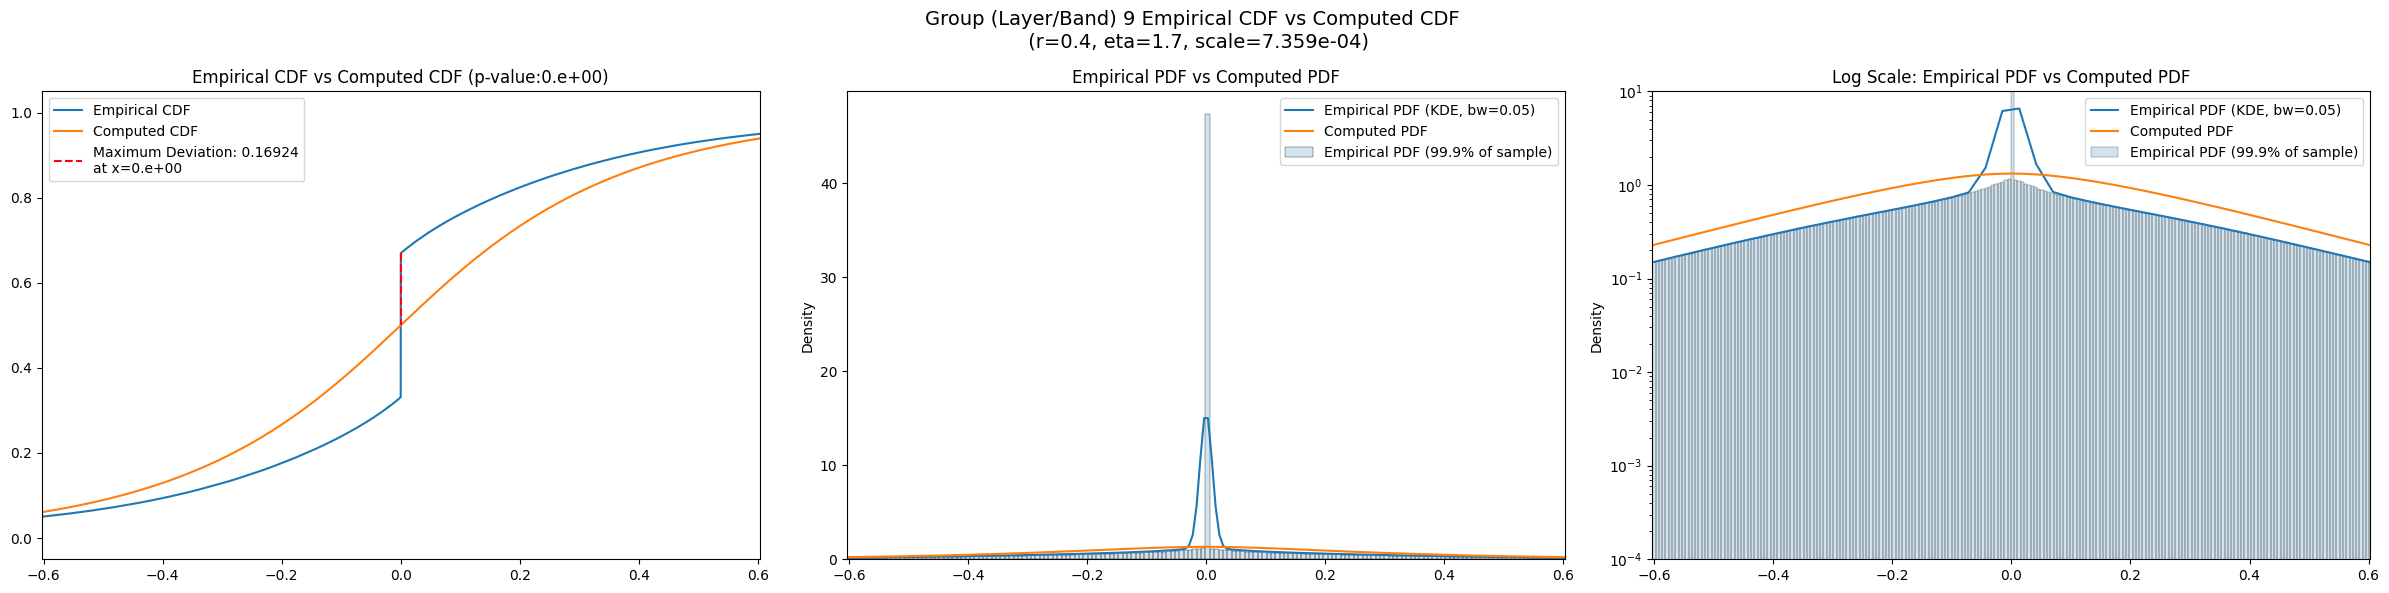

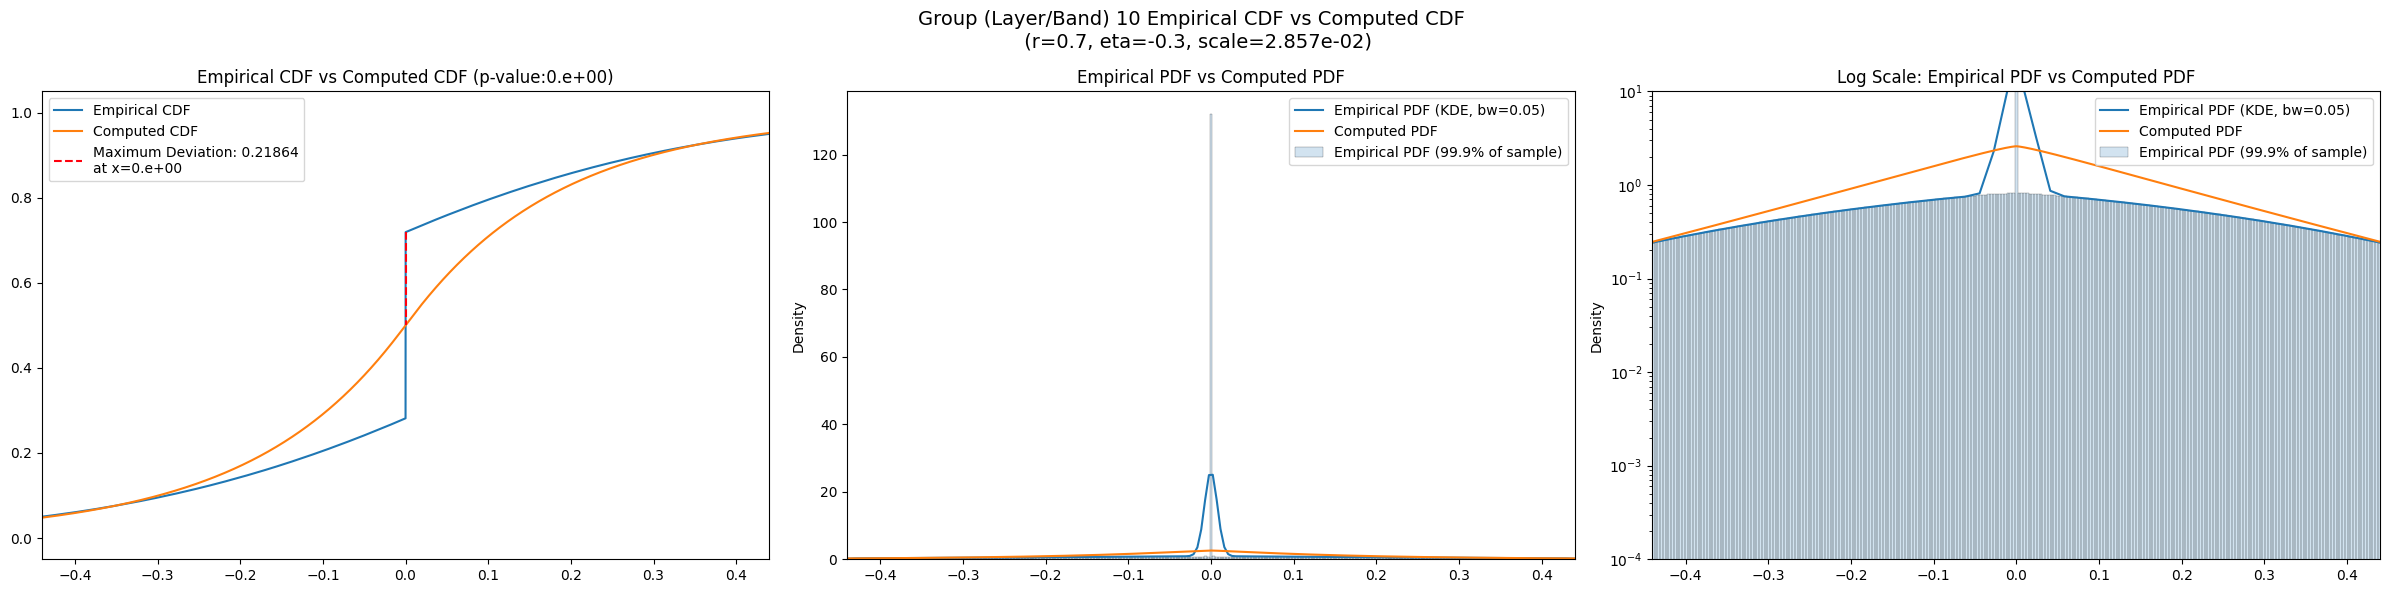

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      2992.346700  2795.771000  3197.442000   2.840140    2.327932   
3       780.423100   728.603940   834.956850   4.924683    3.954512   
4       197.344920   182.717960   212.721620   6.607422    5.379036   
5        45.919570    42.290737    49.782864   8.213636    6.600699   
6        10.315014     9.406057    11.280571  10.381206    8.092984   
7         2.322034     2.104991     2.558147  12.456102    9.404761   
8         0.556196     0.501761     0.618983  14.527348    9.739854   
9         0.165471     0.149907     0.183561  13.340412    8.399303   
10        0.071800     0.066021     0.078448   9.116372    5.449671   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        3.407406           7072             0.010219        9.3         -0.9   
3        6.222755          28288             0.005118        5.4         -1.1   
4        8.421290         113152             0.007230        8.6         -1.2   
5       10.661204         452608             0.013694        0.8         -1.2   
6       14.631648        1810432             0.034520        1.9         -1.3   
7       19.237617        7241728             0.071200        1.4         -1.2   
8       34.173534       28966912             0.118840        1.1         -1.3   
9       32.501076      115867648             0.169240        0.4          1.7   
10      21.428100      463470592             0.218640        0.7         -0.3   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       40.713500              0.042556          1.446220e-11   
3      ...       17.789100              0.053997          3.963580e-72   
4      ...        7.588830              0.067659          0.000000e+00   
5      ...        3.144720              0.076608          0.000000e+00   
6      ...        1.307410              0.082808          0.000000e+00   
7      ...        0.538540              0.091905          0.000000e+00   
8      ...        0.215975              0.118844          0.000000e+00   
9      ...        0.205309              0.169240          0.000000e+00   
10     ...        0.095291              0.218640          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          35.679300             0.017916         2.108660e-02  29.729400   
3          15.166100             0.029188         2.267270e-21  12.313500   
4           6.430210             0.043195        6.887230e-184   5.109830   
5           2.640860             0.053225         0.000000e+00   2.073790   
6           1.066150             0.062534         0.000000e+00   0.830161   
7           0.413402             0.077929         0.000000e+00   0.325987   
8           0.151796             0.118840         0.000000e+00   0.120956   
9           0.332191             0.169240         0.000000e+00   0.205307   
10          0.126888             0.218640         0.000000e+00   0.108196   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.024394   4.347210e-04          4.482603e-01  
3           0.034030   6.767470e-29          4.475637e-01  
4           0.046705  6.190480e-215          1.449628e-05  
5           0.055967   0.000000e+00          4.121765e-74  
6           0.064871   0.000000e+00          0.000000e+00  
7           0.079897   0.000000e+00          0.000000e+00  
8           0.118841   0.000000e+00          0.000000e+00  
9           0.169240   0.000000e+00          0.000000e+00  
10          0.218640   0.000000e+00          0.000000e+00  

[9 rows x 30 

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.010219                 0.016126          0.010219   
3                 0.005118                 0.008069          0.005118   
4                 0.007230                 0.004036          0.007230   
5                 0.013694                 0.002018          0.013690   
6                 0.034520                 0.001009          0.034520   
7                 0.071200                 0.000505          0.071200   
8                 0.118840                 0.000252          0.118840   
9                 0.169240                 0.000126          0.169240   
10                0.218640                 0.000063          0.218640   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.042556             0.017916       0.024394  
3                  0.053997             0.029188       0.034030  
4                  0.067659             0.043195       0.046705  
5                  0.076608             0.053225       0.055967  
6                  0.082808             0.062534       0.064871  
7                  0.091905             0.077929       0.079897  
8                  0.118844             0.118840       0.118841  
9                  0.169240             0.169240       0.169240  
10                 0.218640             0.218640       0.218640

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta   best_scale  \
layer                                                                        
2             2647.723600          0.010219     9.3     -0.90  7369.889380   
3              707.823060          0.005118     5.4     -1.10  2635.649290   
4              183.256090          0.007230     8.6     -1.20   835.297317   
5               45.919571          0.013690     1.1     -1.23   182.219545   
6               10.315014          0.034520     1.9     -1.30    65.461617   
7                2.322034          0.071200     1.4     -1.20     9.468160   
8                0.556196          0.118840     1.1     -1.30     2.956975   
9                0.165471          0.169240     0.4      1.70     0.000736   
10               0.071800          0.218640     0.7     -0.30     0.028566   

       best_exclude_cutoff  
layer                       
2                     25.0  
3                     50.0  
4                    100.0  
5                      0.0  
6                      0.0  
7                      0.0  
8                      0.0  
9                      0.0  
10                     0.0

In [21]:
eng.quit()